In [1]:
!pip install einops
!pip install timm
!pip install peft
!pip install roboflow git+https://github.com/roboflow/supervision.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
# from transformers import (
#     AdamW,
#     AutoModelForCausalLM,
#     AutoProcessor,
#     get_scheduler
# )
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoProcessor

# Check available GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

# Checkpoint and model configuration
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'

# Device configuration with multi-GPU support
if num_gpus > 1:
    # Use DataParallel for multi-GPU training
    device = torch.device("cuda")

    # Load model to first GPU initially
    model = AutoModelForCausalLM.from_pretrained(
        CHECKPOINT,
        trust_remote_code=True,
        revision=REVISION,
        device_map="cuda:0"
    )

    # Wrap model with DataParallel
    model = torch.nn.DataParallel(model)
    model.to(device)
else:
    # Single GPU or CPU fallback
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AutoModelForCausalLM.from_pretrained(
        CHECKPOINT,
        trust_remote_code=True,
        revision=REVISION
    ).to(device)

# Load processor
processor = AutoProcessor.from_pretrained(
    CHECKPOINT,
    trust_remote_code=True,
    revision=REVISION
)

# Optional: Print model device placement
print("Model device:", next(model.parameters()).device)

Number of available GPUs: 1



The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

Importing from timm.models.layers is deprecated, please import via timm.layers


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Model device: cuda:0


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Npr82rgYiQ5A5trJBlb8")
project = rf.workspace("capstone2025-mifho").project("military-base-object-detection")
version = project.version(12)
dataset = version.download("florence2-od")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Military-Base-Object-Detection-12 in florence2-od:: 100%|██████████| 12713/12713 [00:04<00:00, 2621.27it/s]


In [6]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"gettyimages-71282058-612x612_jpg.rf.ab7c3b4ca983d624059ba5dadb9d4b65.jpg","prefix":"<OD>","suffix":"Grenade<loc_528><loc_228><loc_641><loc_315>Knife<loc_245><loc_431><loc_555><loc_816>Knife<loc_238><loc_548><loc_397><loc_796>Pistol<loc_274><loc_304><loc_507><loc_431>"}
{"image":"13_mp4-8_jpg.rf.a5296548fd2ca25609f2b88e14e6a8cc.jpg","prefix":"<OD>","suffix":"Soldier<loc_316><loc_278><loc_352><loc_395>"}
{"image":"1_mp4-103_jpg.rf.84fda5ee02c05330e4527a0411f265db.jpg","prefix":"<OD>","suffix":"Soldier<loc_303><loc_30><loc_555><loc_999>"}
{"image":"aircraft_83_jpg.rf.276b81f54d8af8482ff4873fd80ad392.jpg","prefix":"<OD>","suffix":"Aircraft<loc_51><loc_377><loc_105><loc_444>Aircraft<loc_17><loc_326><loc_72><loc_385>Aircraft<loc_42><loc_573><loc_95><loc_629>Aircraft<loc_325><loc_432><loc_376><loc_488>Aircraft<loc_286><loc_322><loc_315><loc_346>Aircraft<loc_235><loc_236><loc_265><loc_262>Aircraft<loc_326><loc_224><loc_354><loc_248>Aircraft<loc_425><loc_371><loc_477><loc_427>Aircraft

In [7]:
# @title Define `DetectionsDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [8]:
# @title Initiate `DetectionsDataset` and `DataLoader` for train and validation subsets

BATCH_SIZE = 4
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/train/annotations.jsonl",
    image_directory_path = f"{dataset.location}/train/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)
test_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/test/annotations.jsonl",
    image_directory_path = f"{dataset.location}/test/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [9]:
# 1. Required imports
from peft import LoraConfig, get_peft_model
import torch

# 2. Unwrap model if it's DataParallel
if isinstance(model, torch.nn.DataParallel):
    model = model.module

# 3. Modified LoRA config
config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

# 4. Create PEFT model
peft_model = get_peft_model(model, config)

# 5. Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [10]:
torch.cuda.empty_cache()

from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



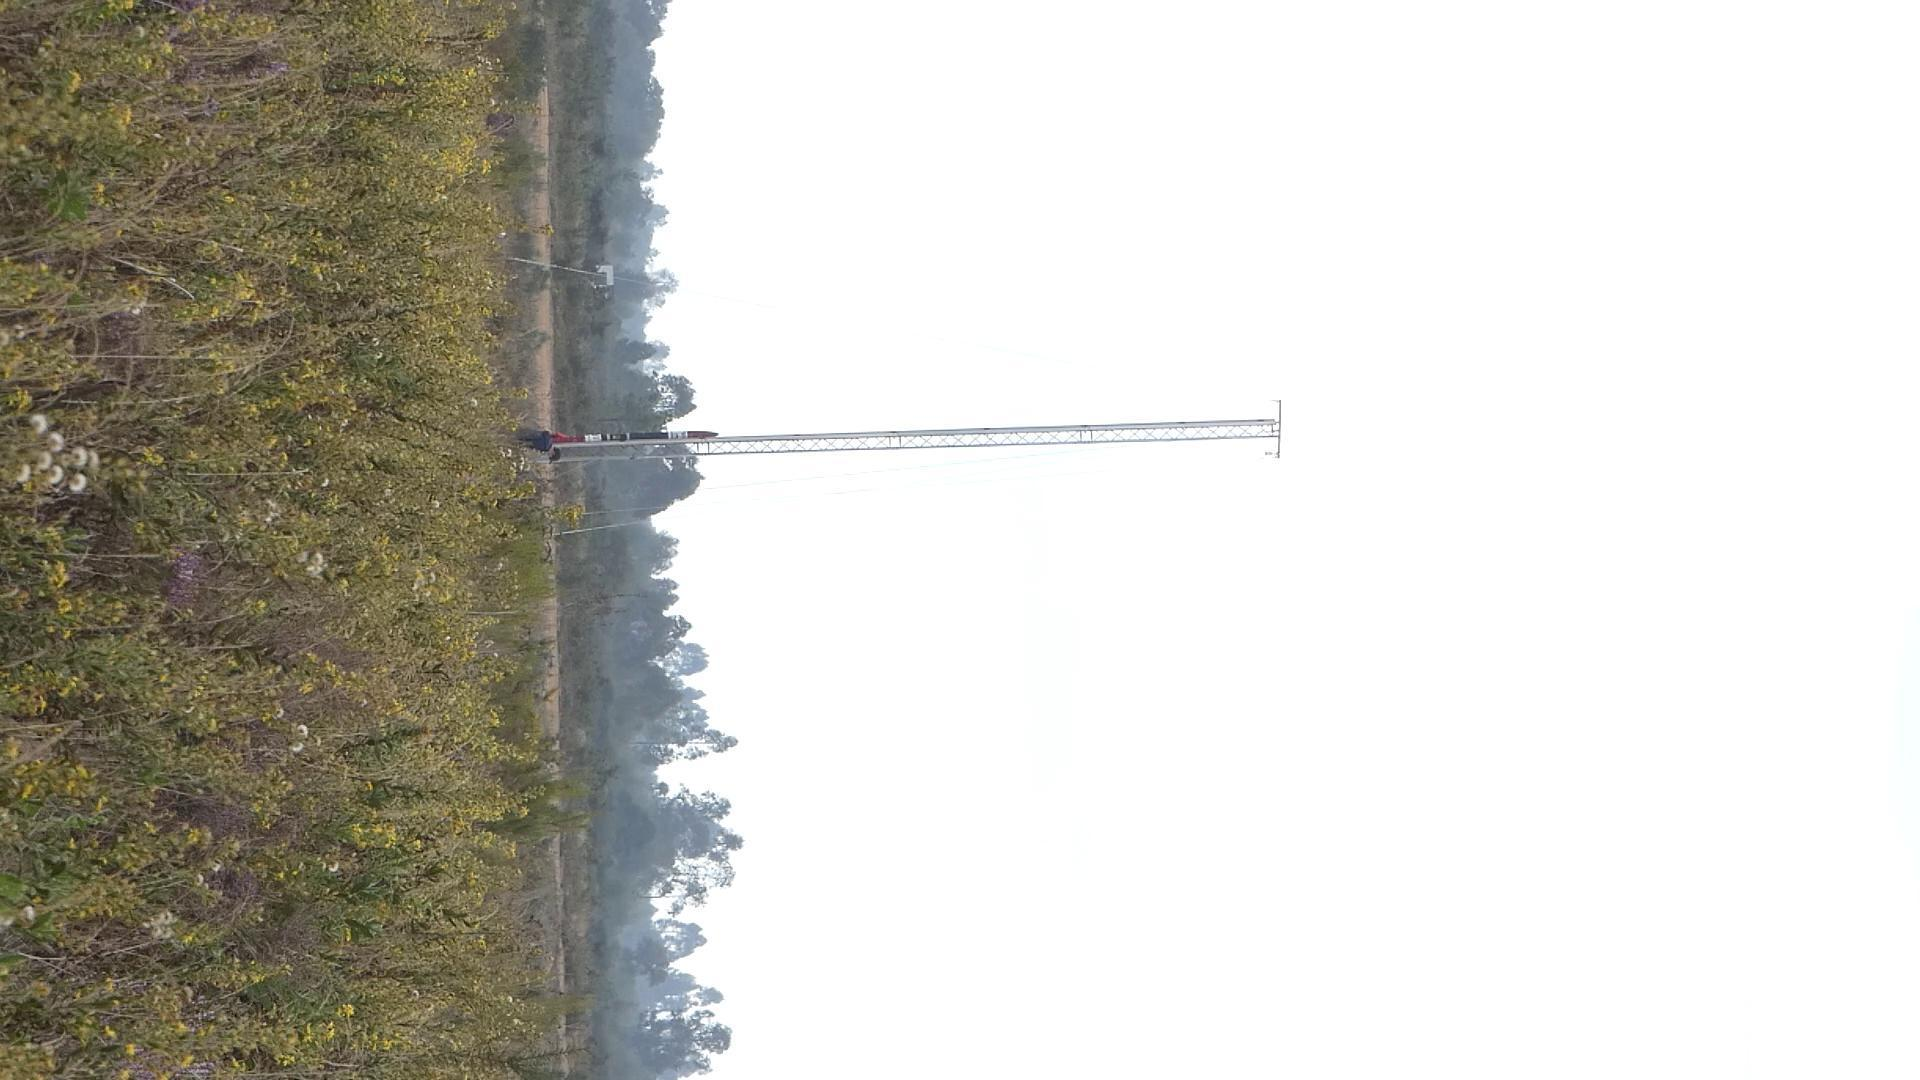
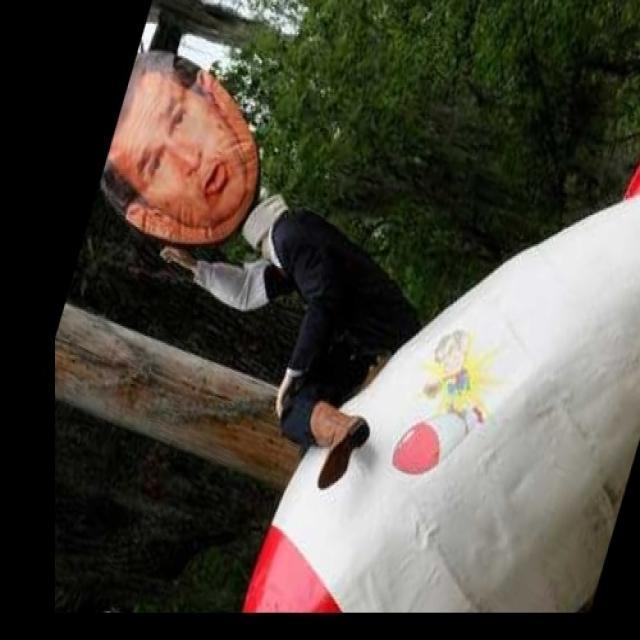
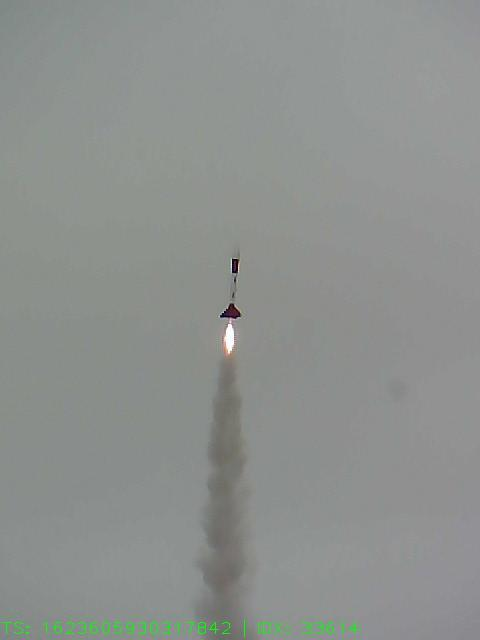
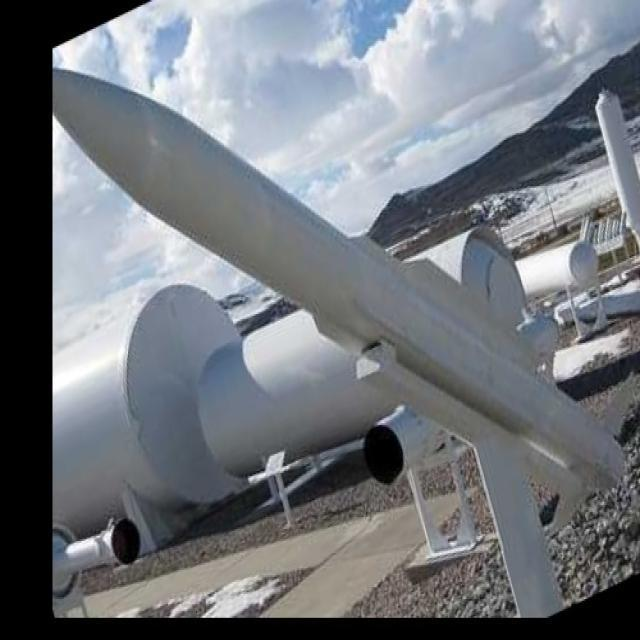

In [11]:
import io
import base64
import json
import html
from PIL import Image
import supervision as sv
from IPython.display import HTML, display
import torch

# Define DEVICE constant
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Inference functions
def render_inline(image: Image.Image, resize=(128, 128)):
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to render model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""

def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

# Run inference
render_inference_results(peft_model, val_dataset,4)

## Fine-tune Florence-2 on custom object detection dataset

In [12]:
import os
import torch
from tqdm import tqdm
from torch.optim import AdamW
from transformers import get_scheduler

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6, patience=3):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    best_val_loss = float("inf")
    patience_counter = 0

    render_inference_results(model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            # Check for early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                print(f"Patience Counter: {patience_counter}/{patience}")
                if patience_counter >= patience:
                    print("Stopping training early due to overfitting.")
                    break

            render_inference_results(model, val_loader.dataset, 6)

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



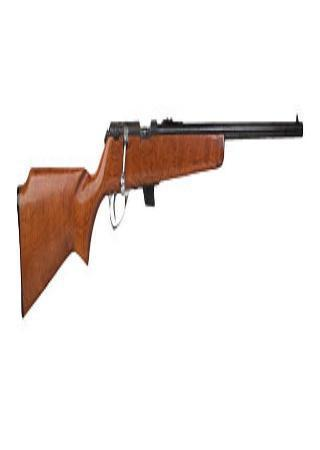
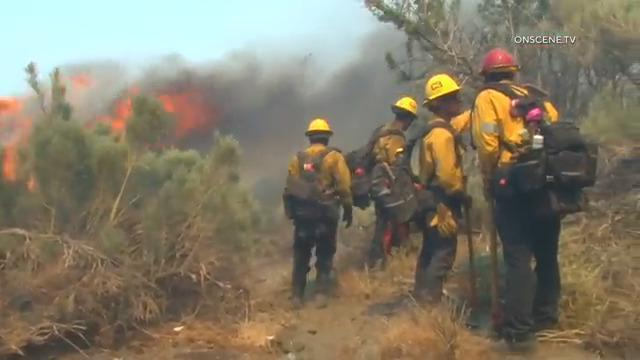
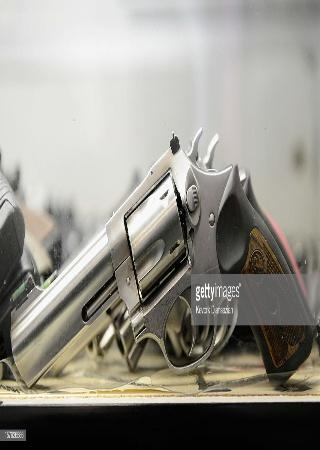
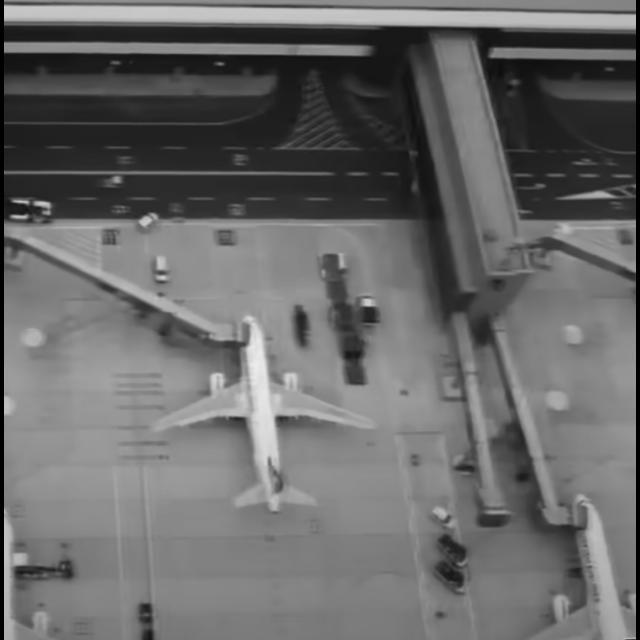
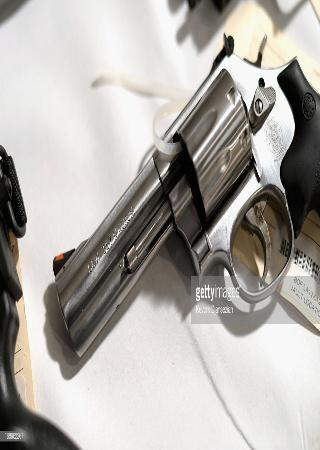
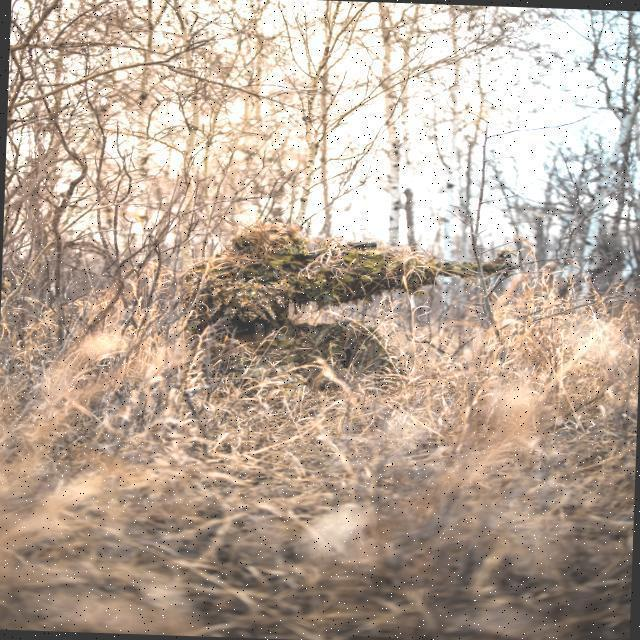

Training Epoch 1/20: 100%|██████████| 2438/2438 [22:28<00:00,  1.81it/s]


Average Training Loss: 1.6004205005299956


Validation Epoch 1/20: 100%|██████████| 39/39 [00:13<00:00,  2.93it/s]


Average Validation Loss: 1.8775440607315454


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



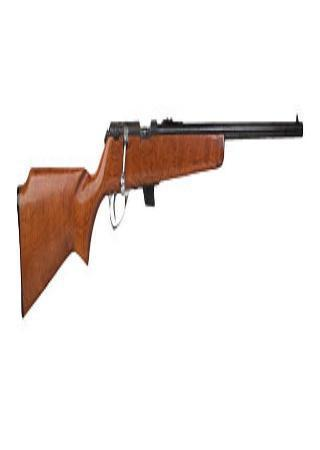
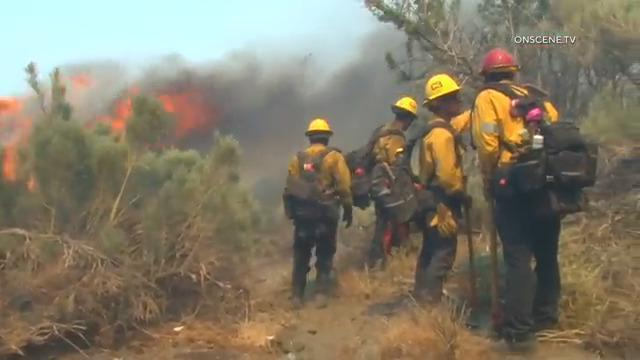
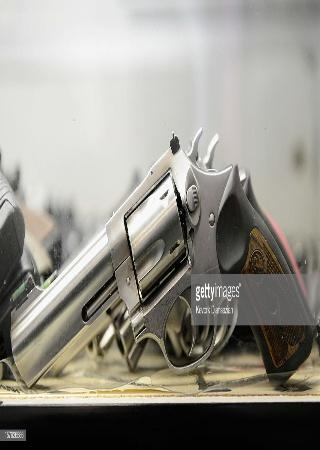
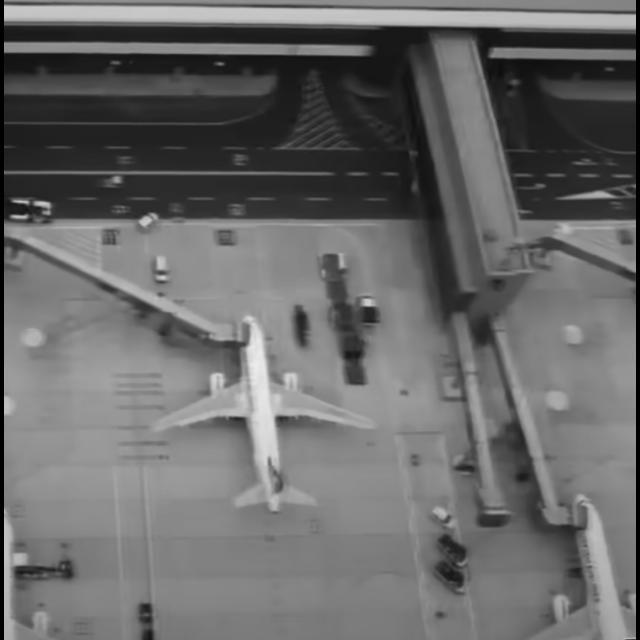
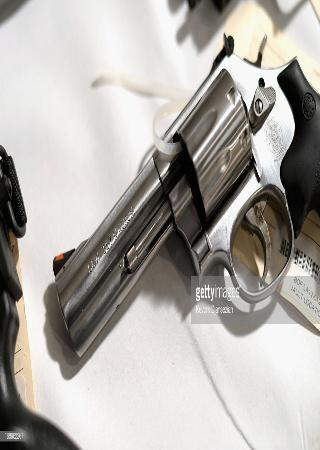
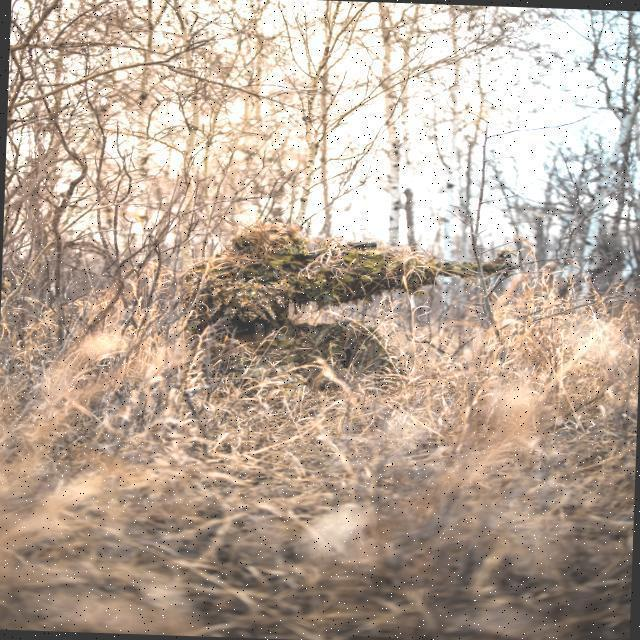

Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
Training Epoch 2/20: 100%|██████████| 2438/2438 [22:31<00:00,  1.80it/s]


Average Training Loss: 1.5850194962030557


Validation Epoch 2/20: 100%|██████████| 39/39 [00:13<00:00,  2.92it/s]


Average Validation Loss: 1.8060008669510865


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



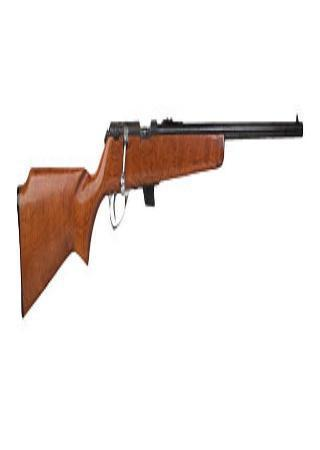
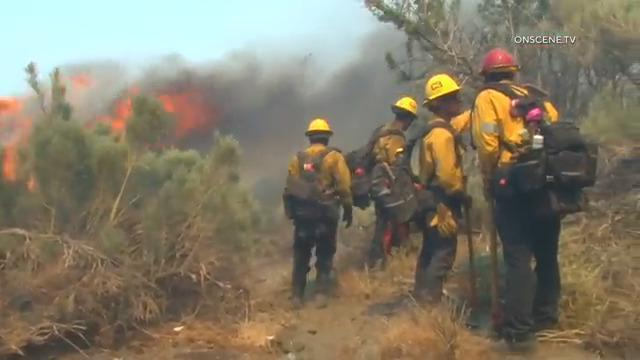
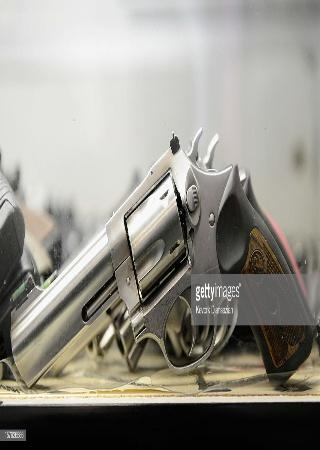
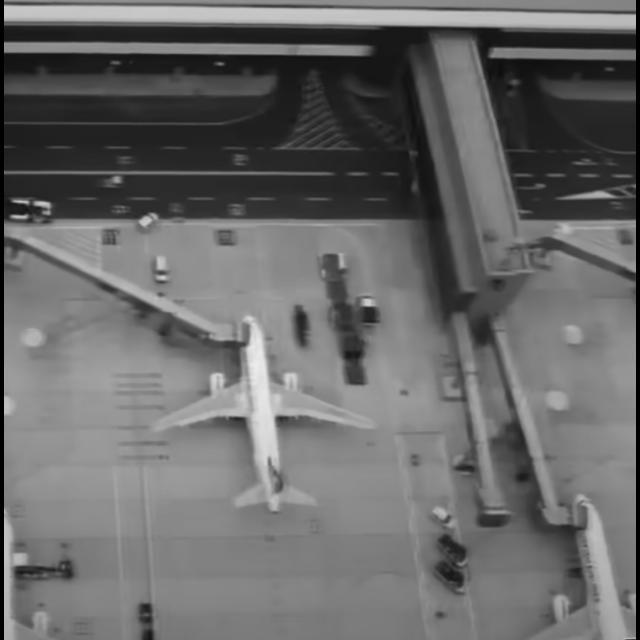
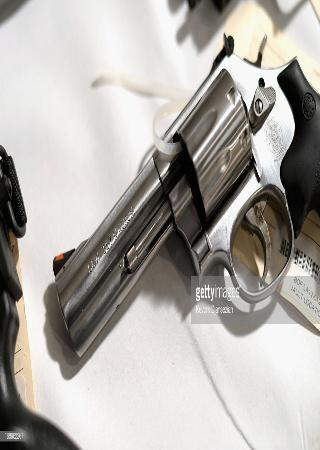
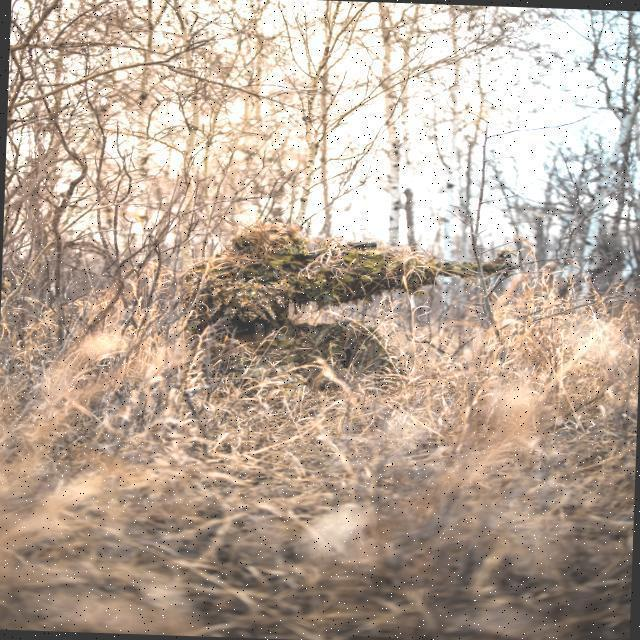

Training Epoch 3/20: 100%|██████████| 2438/2438 [22:31<00:00,  1.80it/s]


Average Training Loss: 1.5059276807494004


Validation Epoch 3/20: 100%|██████████| 39/39 [00:13<00:00,  2.93it/s]


Average Validation Loss: 1.8254487621478546
Patience Counter: 1/3


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



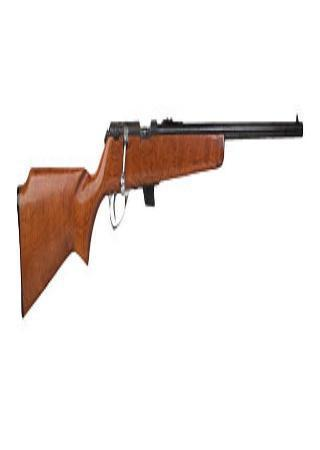
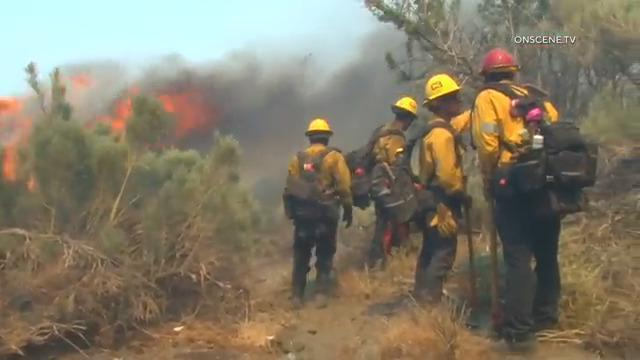
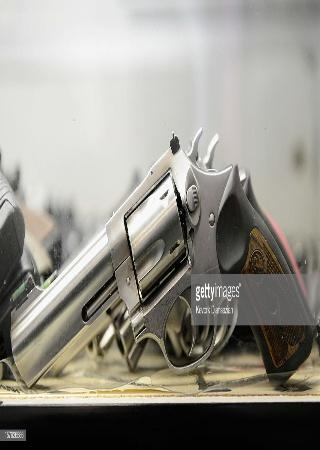
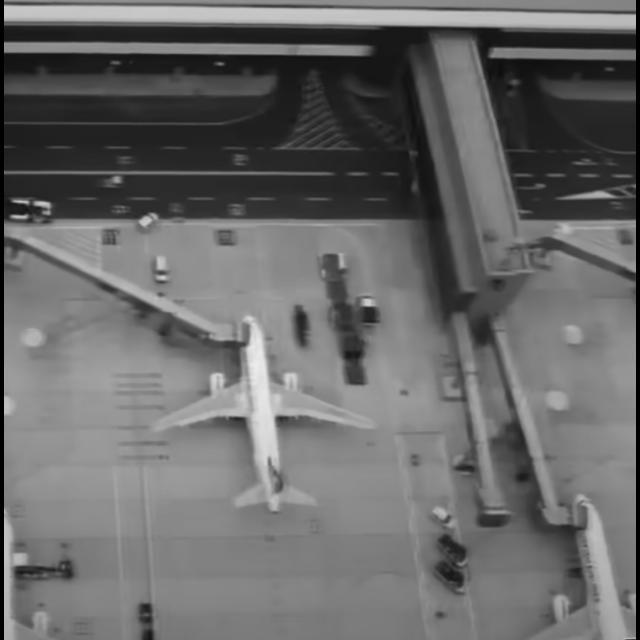
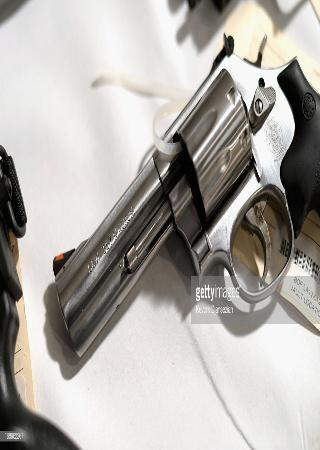
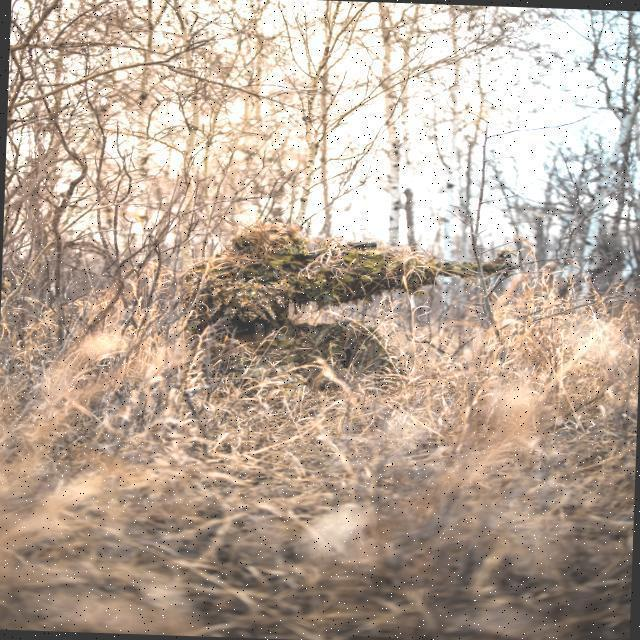

Training Epoch 4/20: 100%|██████████| 2438/2438 [22:31<00:00,  1.80it/s]


Average Training Loss: 1.5217202481820604


Validation Epoch 4/20: 100%|██████████| 39/39 [00:13<00:00,  2.92it/s]


Average Validation Loss: 1.7252669349694862


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



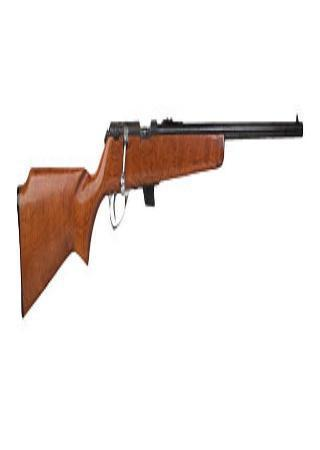
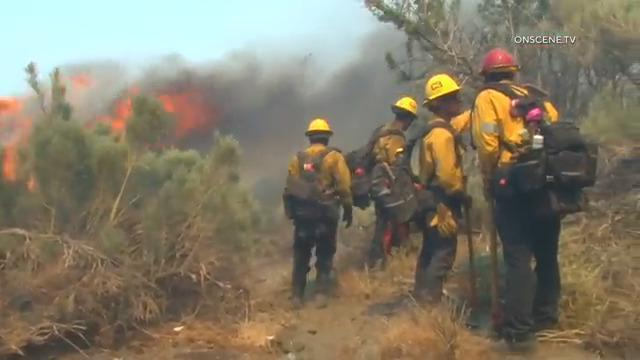
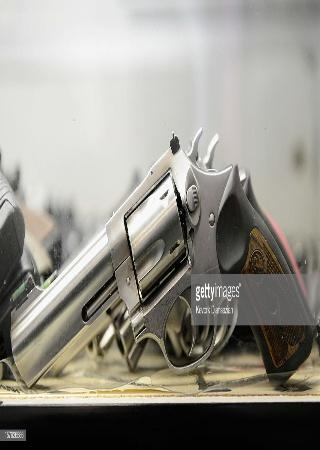
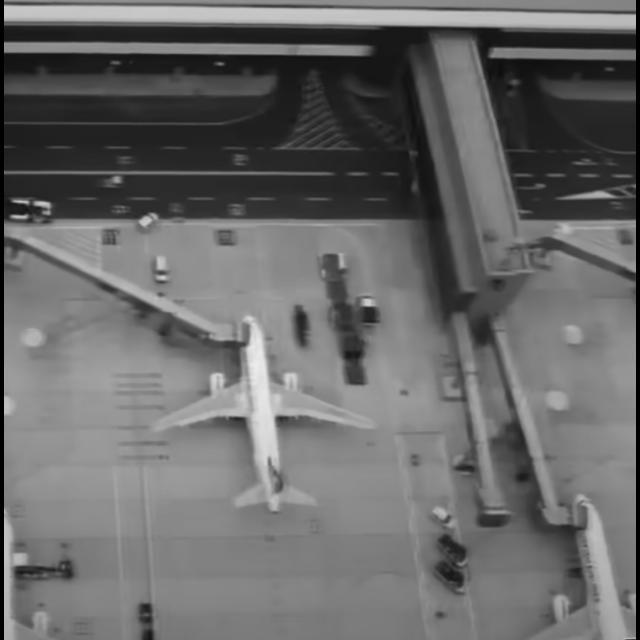
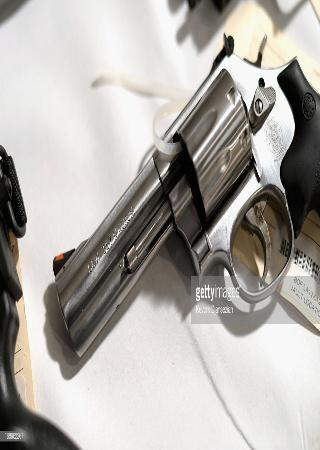
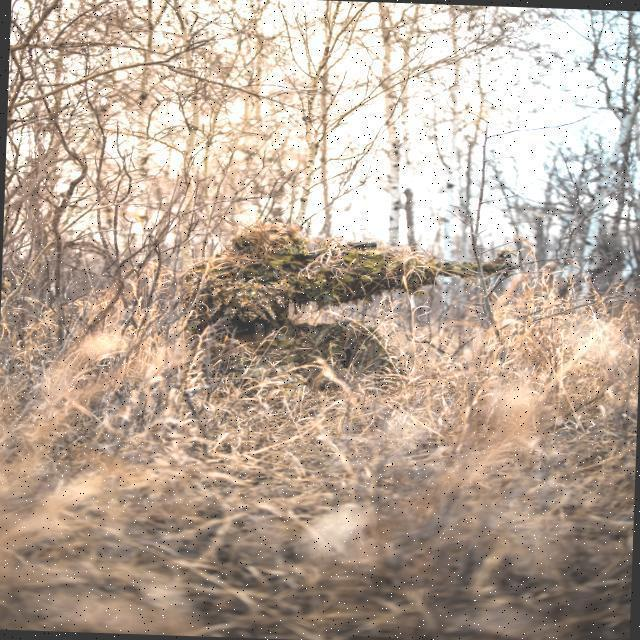

Training Epoch 5/20: 100%|██████████| 2438/2438 [22:30<00:00,  1.81it/s]


Average Training Loss: 1.3864353931859636


Validation Epoch 5/20: 100%|██████████| 39/39 [00:13<00:00,  2.92it/s]


Average Validation Loss: 1.7060086604876397


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



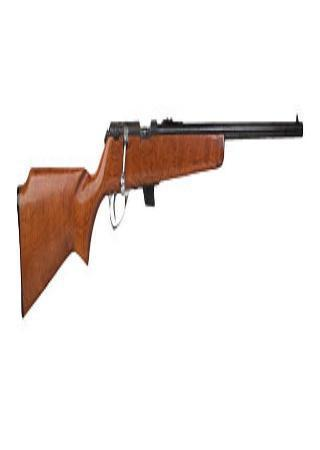
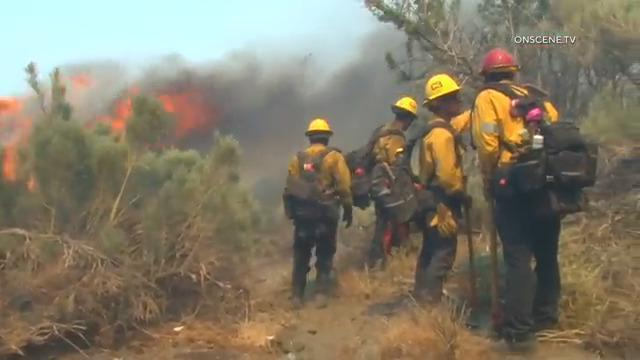
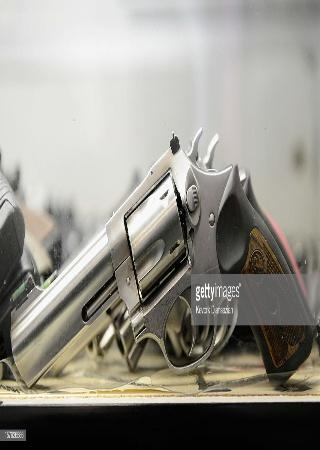
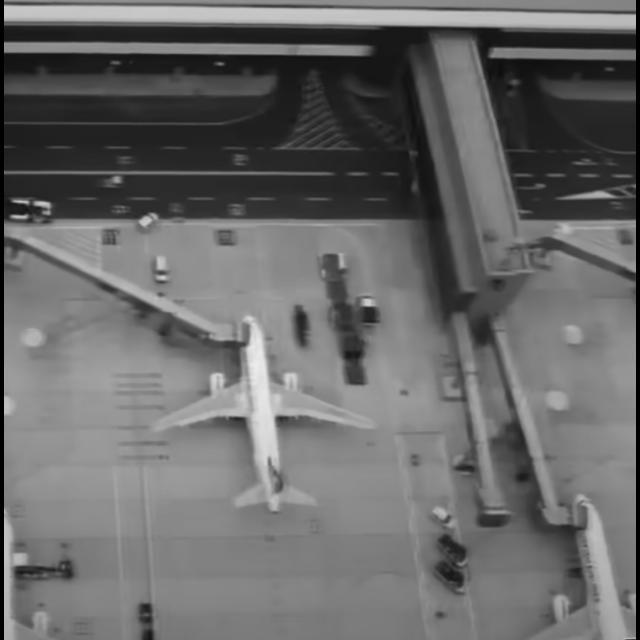
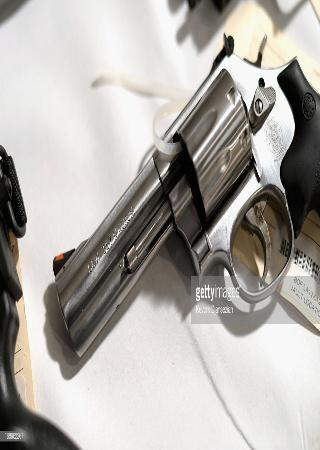
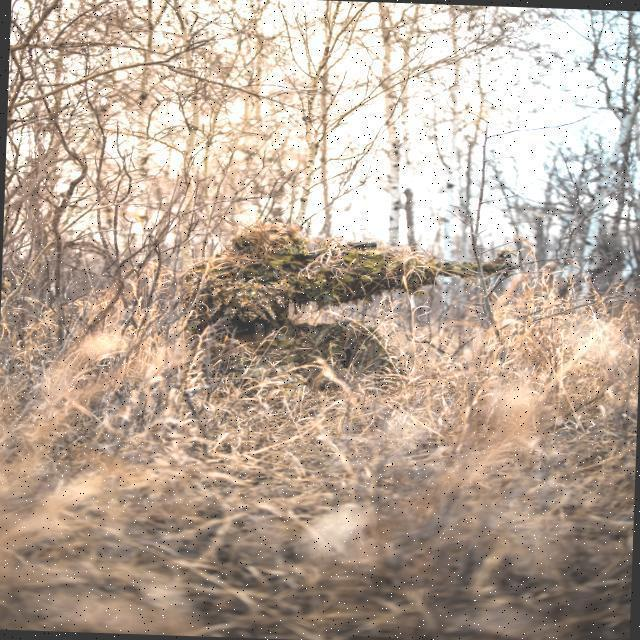

Training Epoch 6/20: 100%|██████████| 2438/2438 [22:29<00:00,  1.81it/s]


Average Training Loss: 1.372779255865831


Validation Epoch 6/20: 100%|██████████| 39/39 [00:13<00:00,  2.93it/s]


Average Validation Loss: 1.669775516558916


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



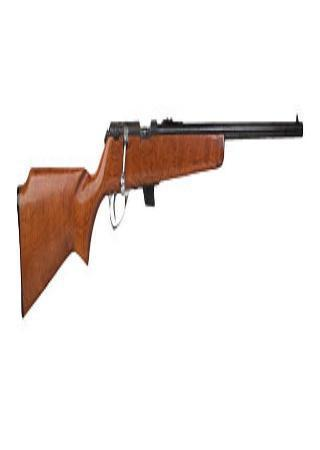
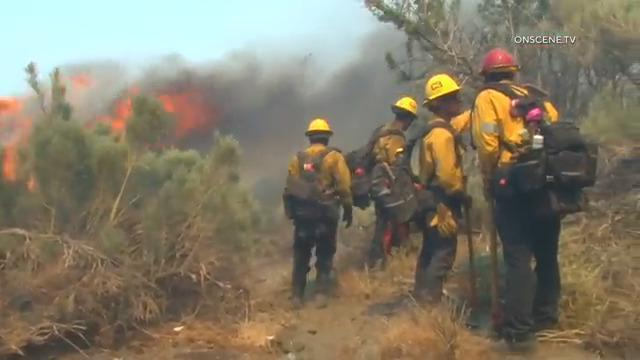
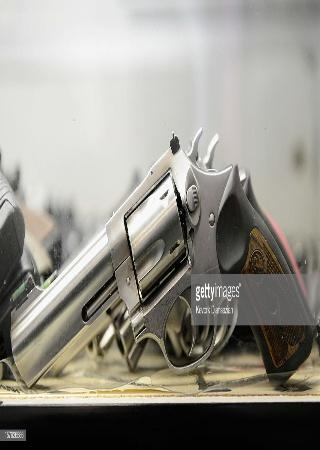
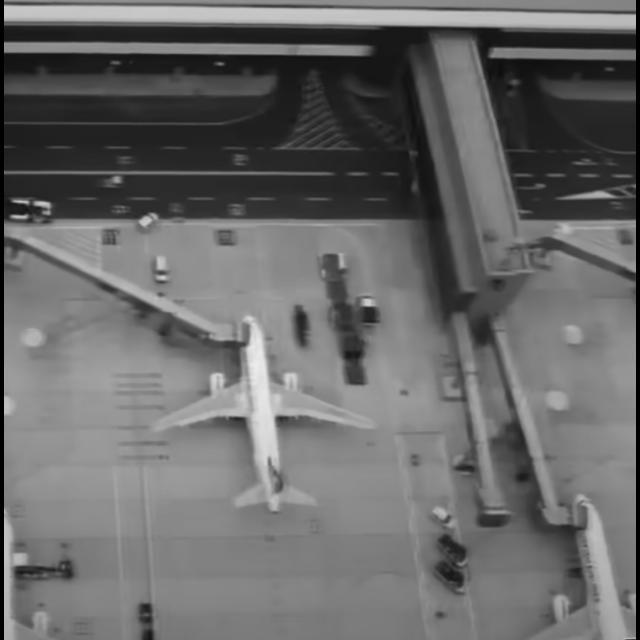
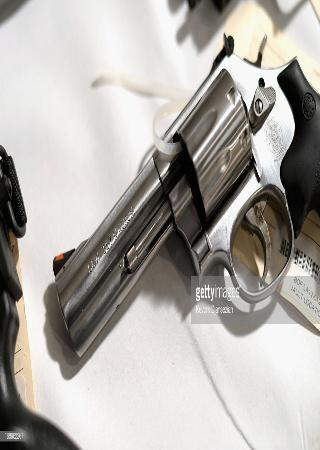
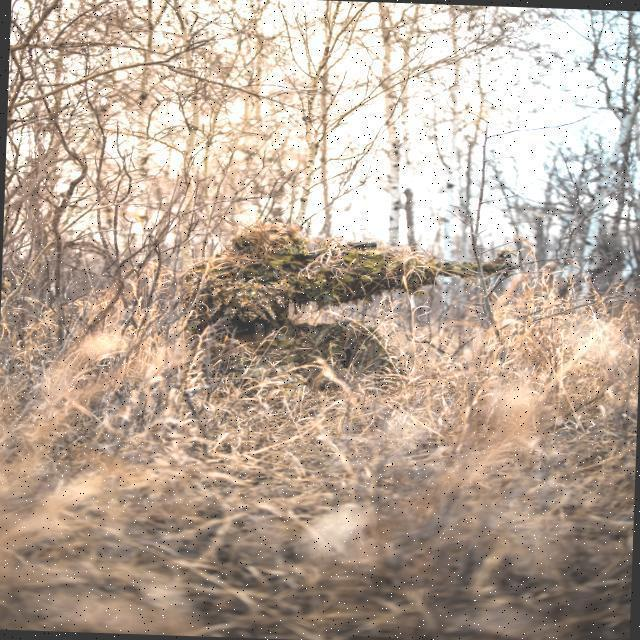

Training Epoch 7/20: 100%|██████████| 2438/2438 [22:34<00:00,  1.80it/s]


Average Training Loss: 1.3296691944014352


Validation Epoch 7/20: 100%|██████████| 39/39 [00:13<00:00,  2.88it/s]


Average Validation Loss: 1.6578176006292686


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



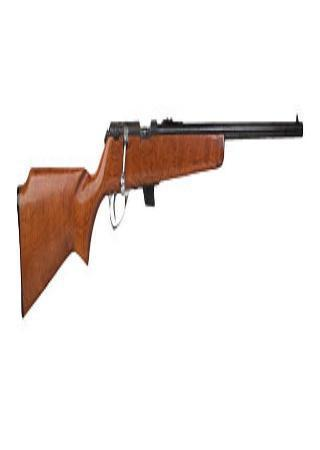
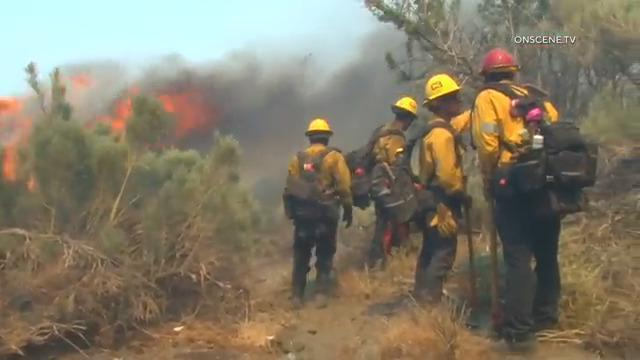
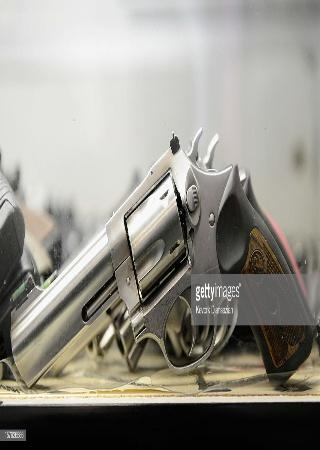
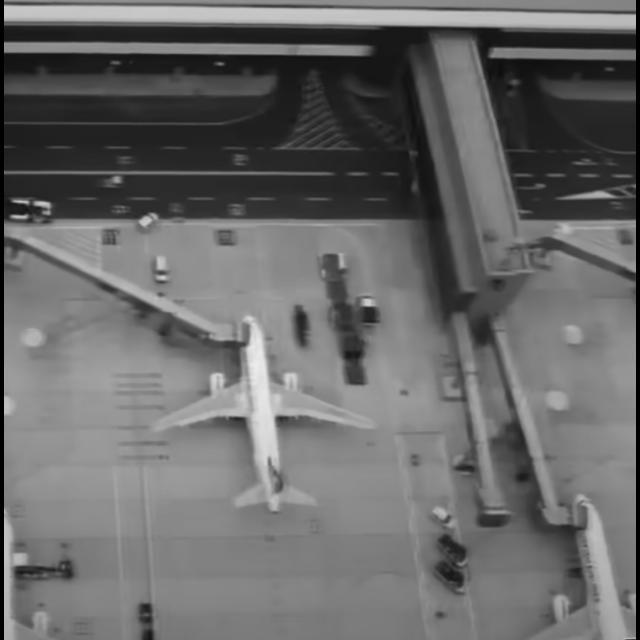
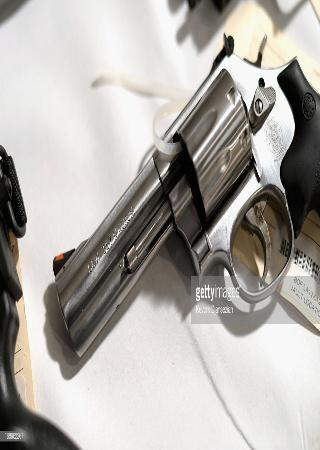
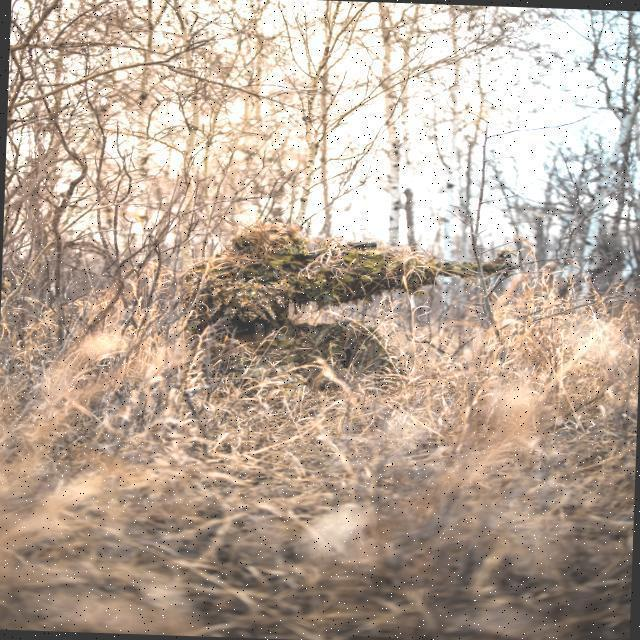

Training Epoch 8/20: 100%|██████████| 2438/2438 [22:34<00:00,  1.80it/s]


Average Training Loss: 1.340193253105248


Validation Epoch 8/20: 100%|██████████| 39/39 [00:13<00:00,  2.94it/s]
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


Average Validation Loss: 1.6341502712323115
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



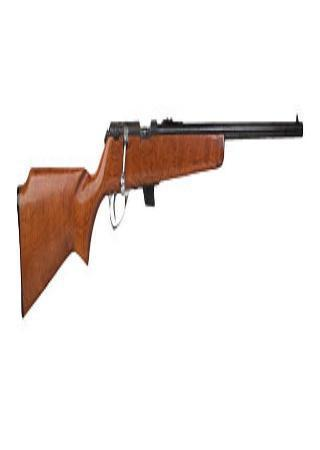
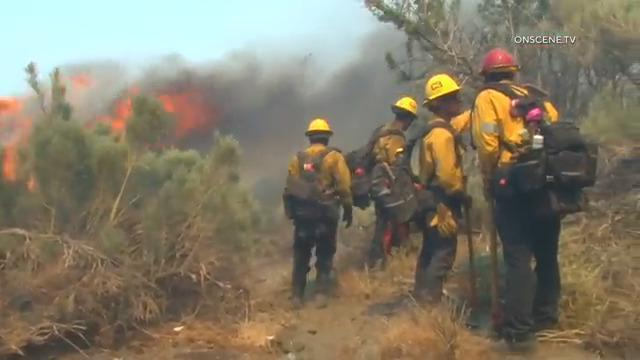
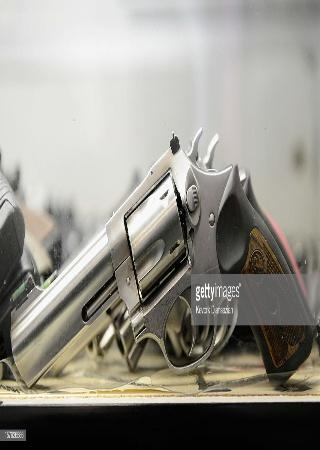
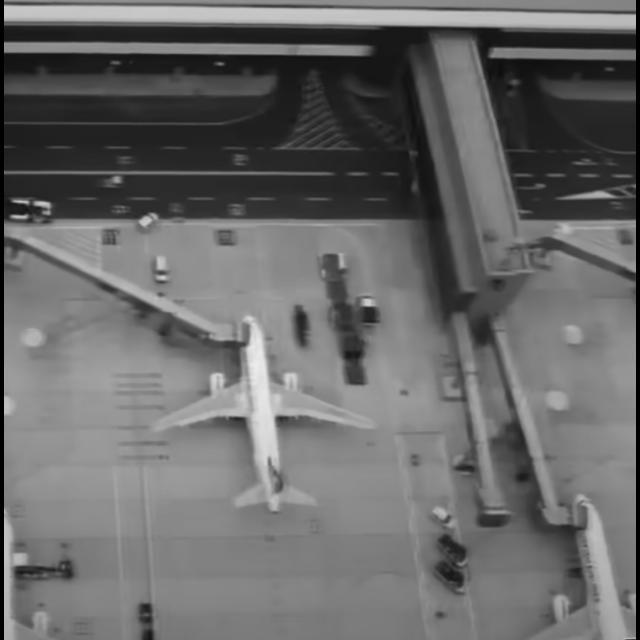
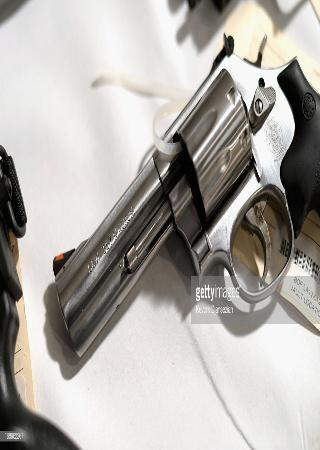
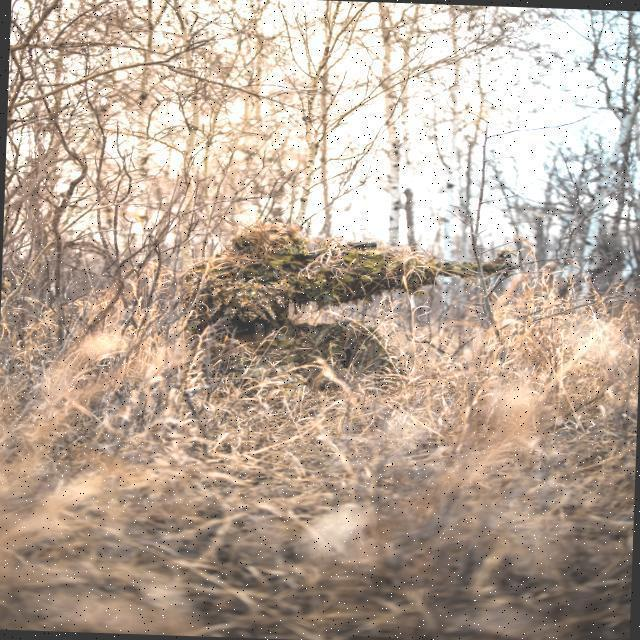

Training Epoch 9/20: 100%|██████████| 2438/2438 [22:31<00:00,  1.80it/s]


Average Training Loss: 1.2525923039895575


Validation Epoch 9/20: 100%|██████████| 39/39 [00:13<00:00,  2.93it/s]


Average Validation Loss: 1.5366435112097325


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



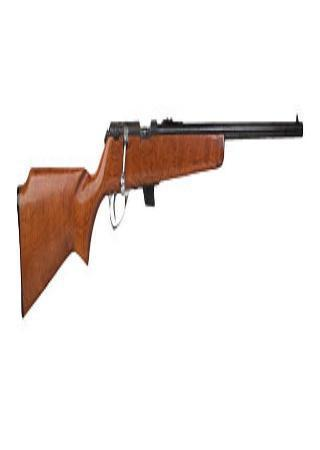
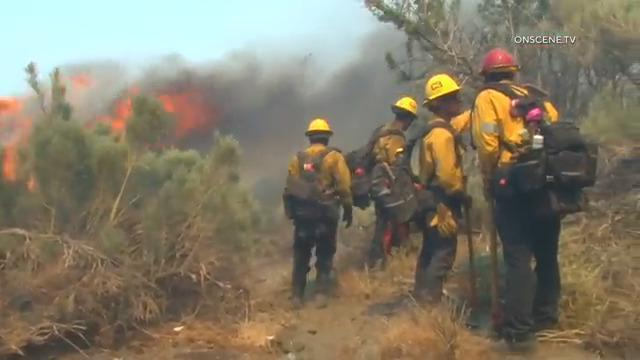
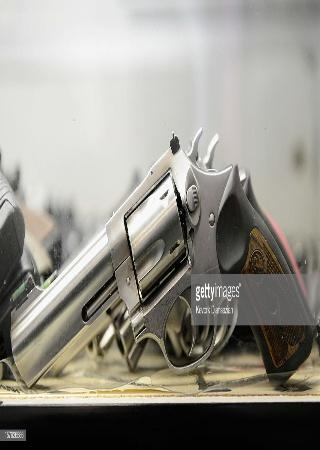
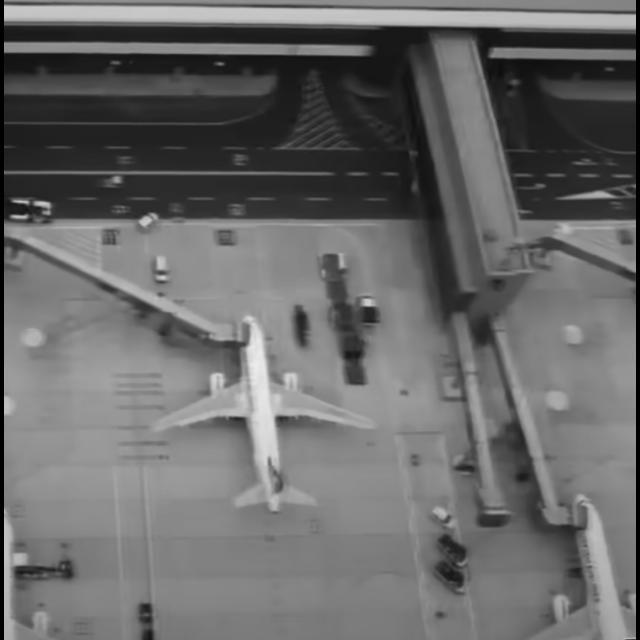
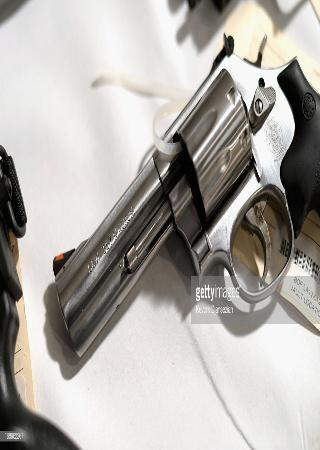
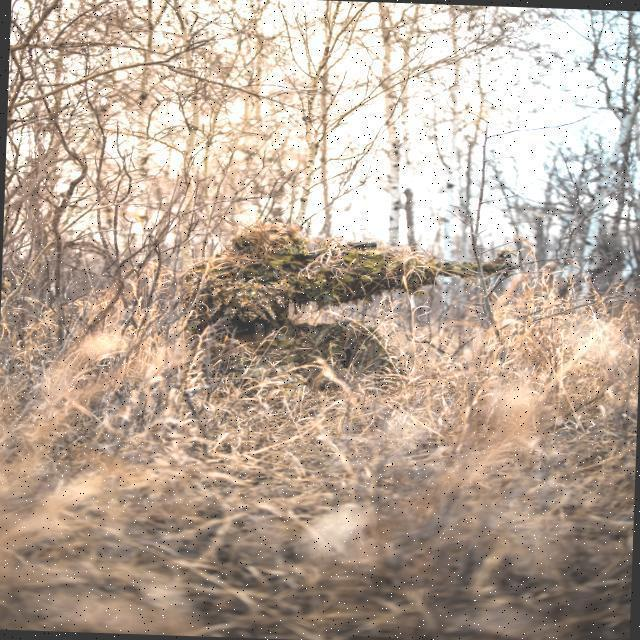

Training Epoch 10/20: 100%|██████████| 2438/2438 [22:30<00:00,  1.81it/s]


Average Training Loss: 1.2007045234149356


Validation Epoch 10/20: 100%|██████████| 39/39 [00:13<00:00,  2.92it/s]


Average Validation Loss: 1.5705950489410987
Patience Counter: 1/3


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



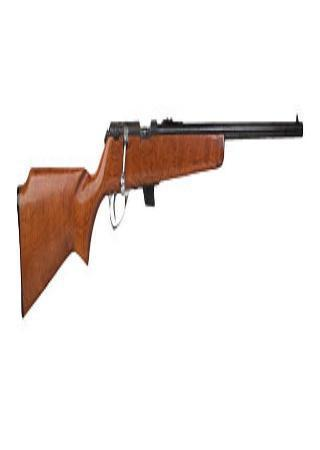
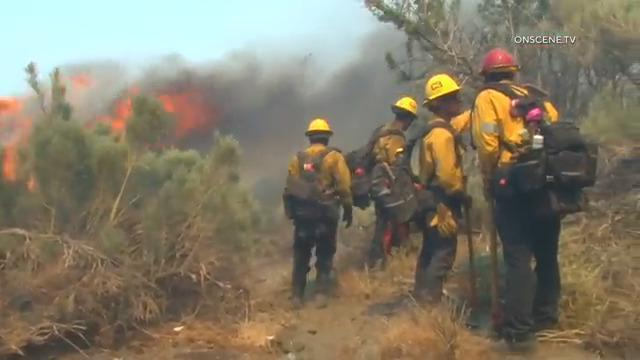
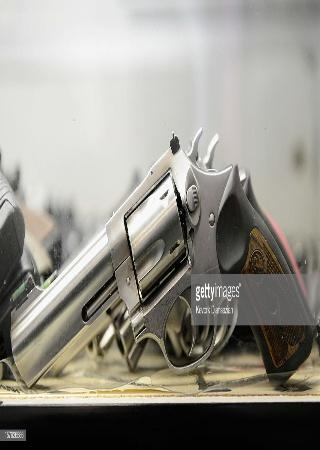
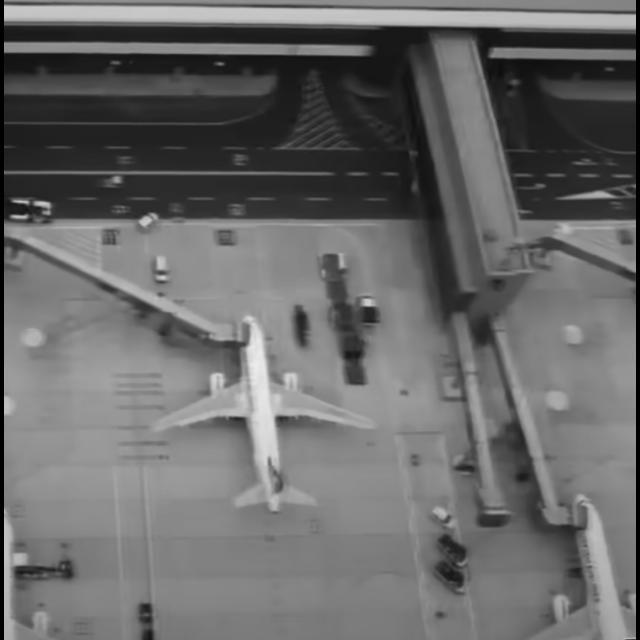
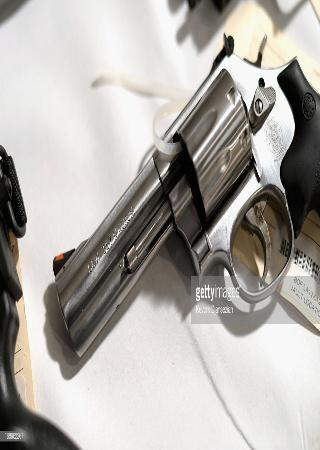
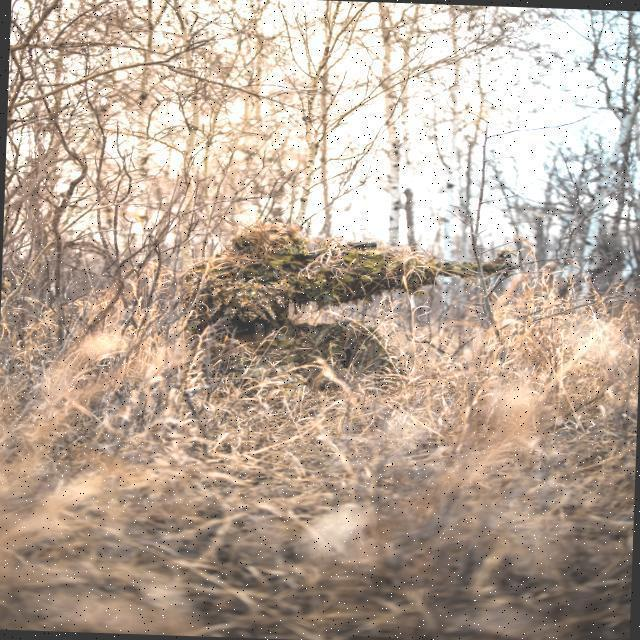

Training Epoch 11/20: 100%|██████████| 2438/2438 [22:29<00:00,  1.81it/s]


Average Training Loss: 1.16549793177936


Validation Epoch 11/20: 100%|██████████| 39/39 [00:13<00:00,  2.93it/s]
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


Average Validation Loss: 1.5555041860311458
Patience Counter: 2/3
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



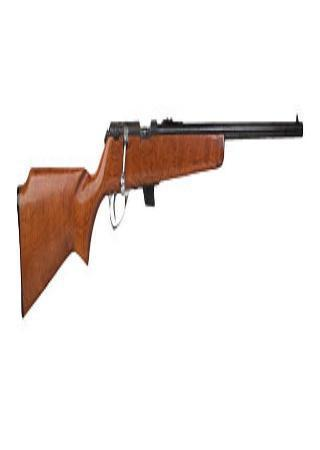
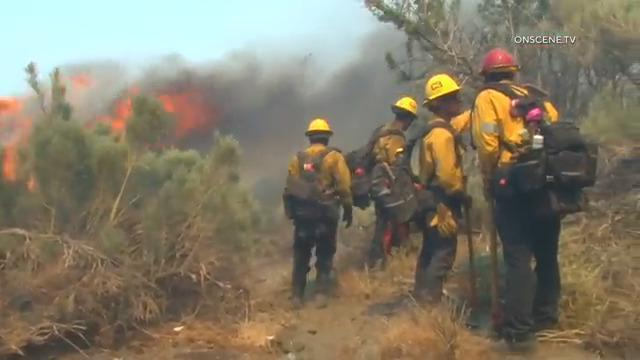
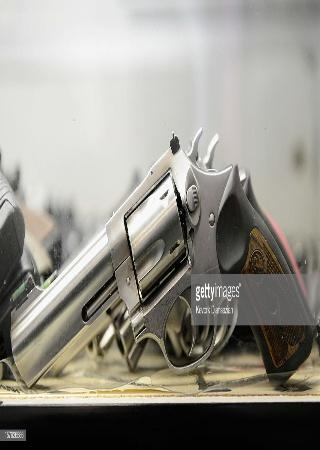
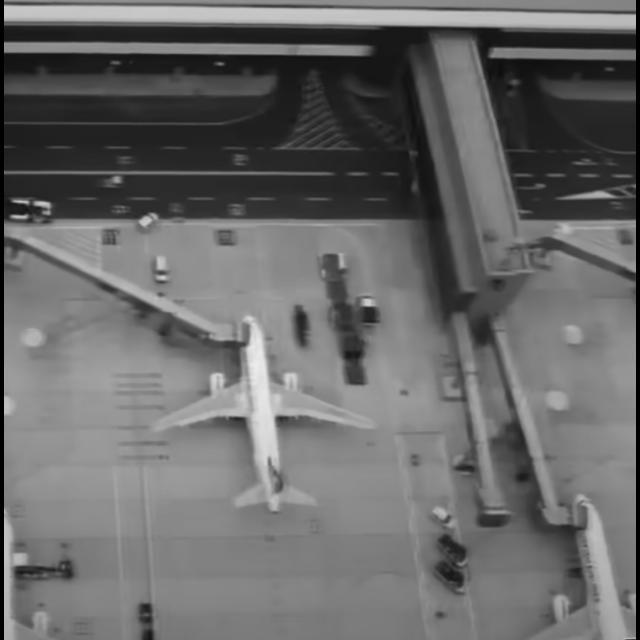
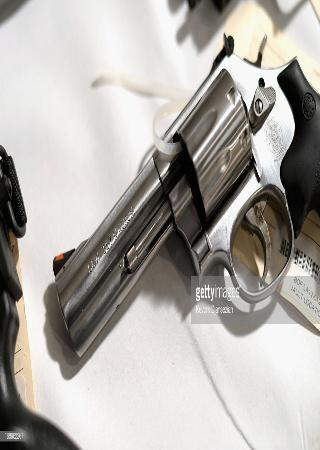
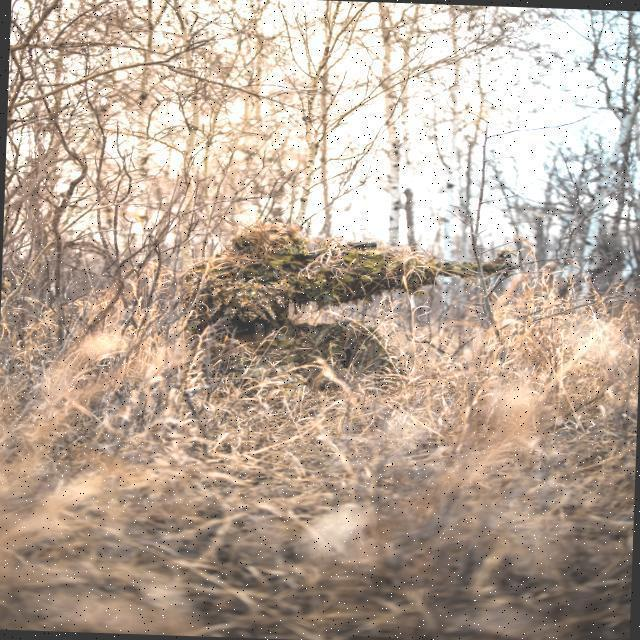

Training Epoch 12/20: 100%|██████████| 2438/2438 [22:31<00:00,  1.80it/s]


Average Training Loss: 1.129073010398483


Validation Epoch 12/20: 100%|██████████| 39/39 [00:13<00:00,  2.92it/s]
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


Average Validation Loss: 1.5161084028390737
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



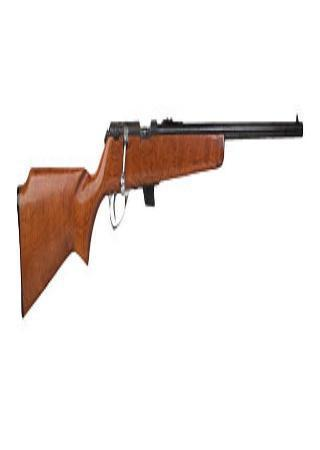
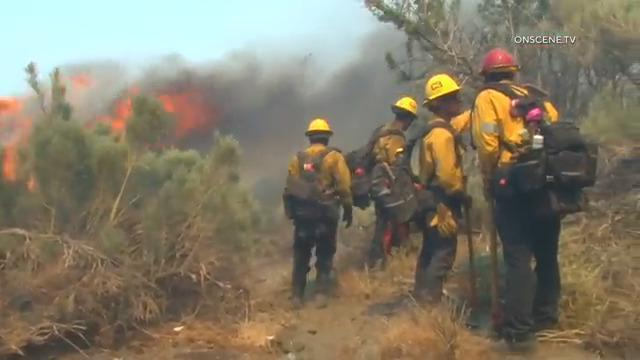
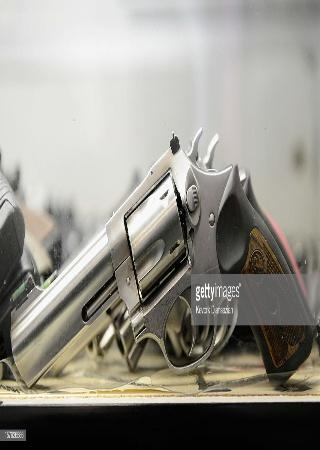
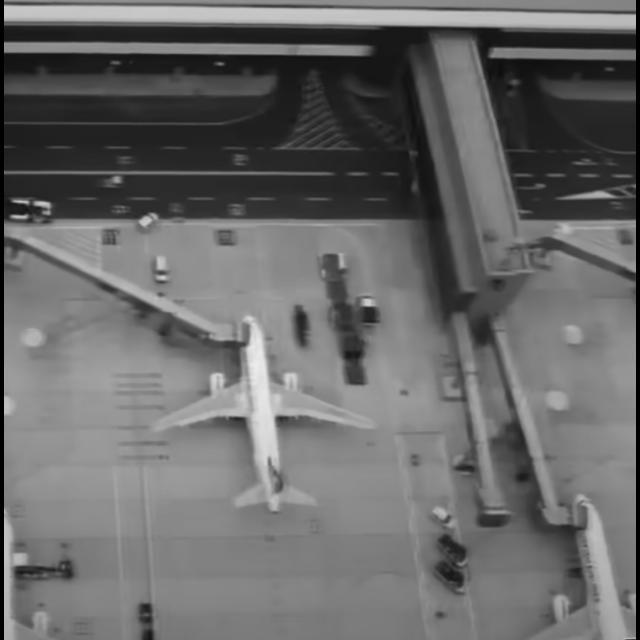
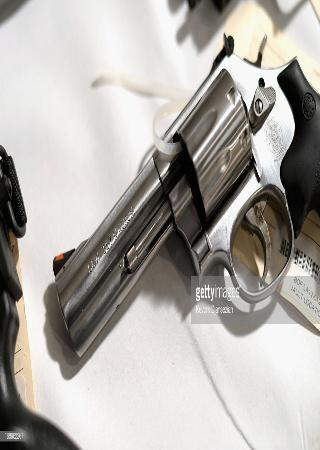
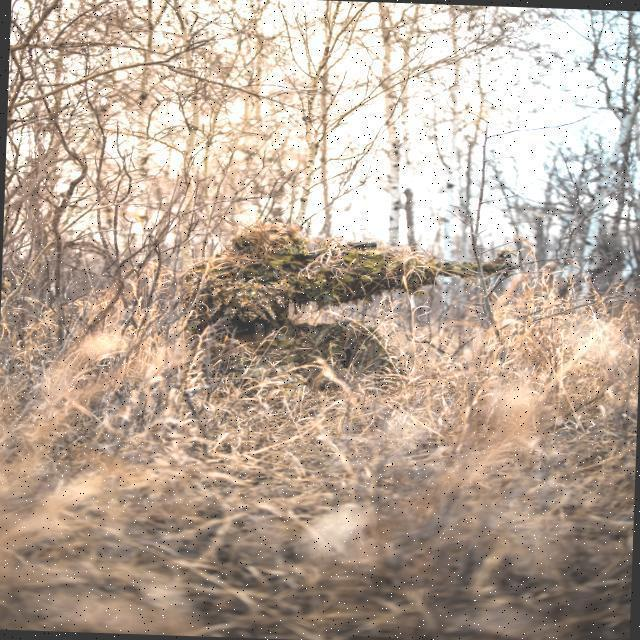

Training Epoch 13/20: 100%|██████████| 2438/2438 [22:35<00:00,  1.80it/s]


Average Training Loss: 1.0958646571567745


Validation Epoch 13/20: 100%|██████████| 39/39 [00:13<00:00,  2.87it/s]


Average Validation Loss: 1.4893415707808275


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



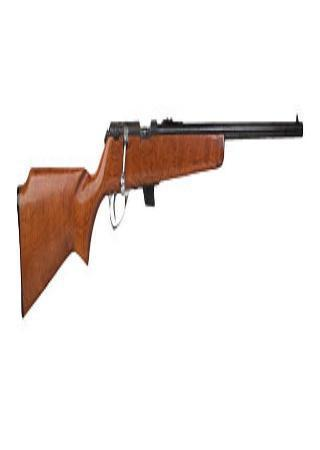
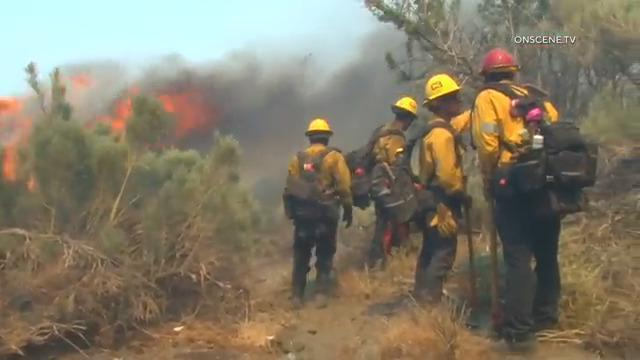
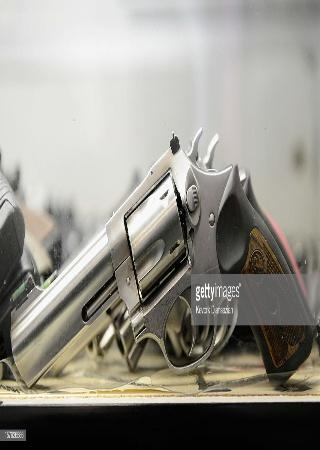
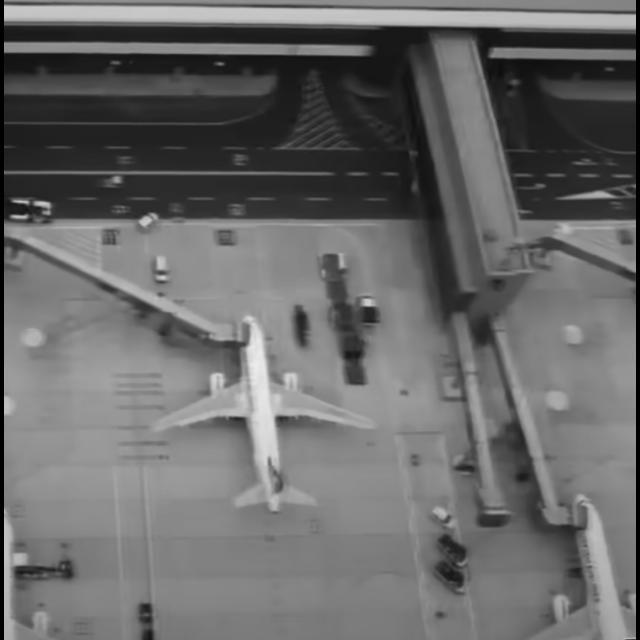
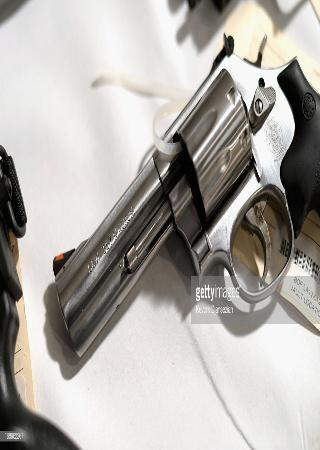
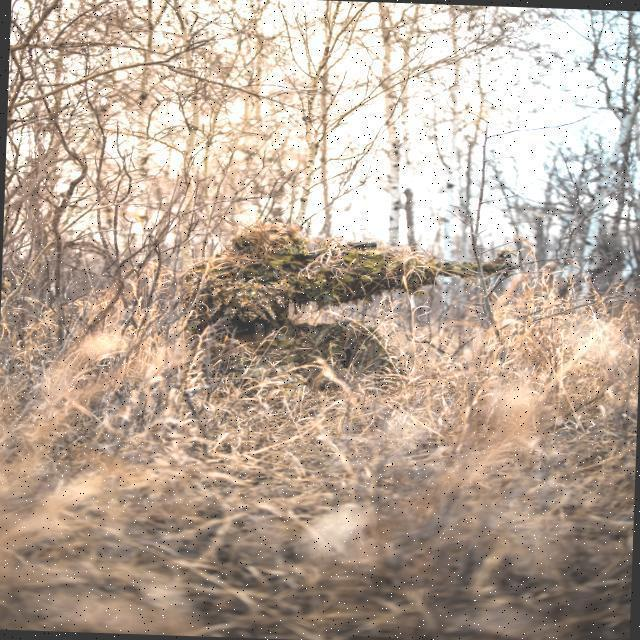

Training Epoch 14/20: 100%|██████████| 2438/2438 [22:43<00:00,  1.79it/s]


Average Training Loss: 1.0688167782691387


Validation Epoch 14/20: 100%|██████████| 39/39 [00:13<00:00,  2.89it/s]


Average Validation Loss: 1.5063821428861373
Patience Counter: 1/3


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.


failed to render model response
failed to render model response


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.



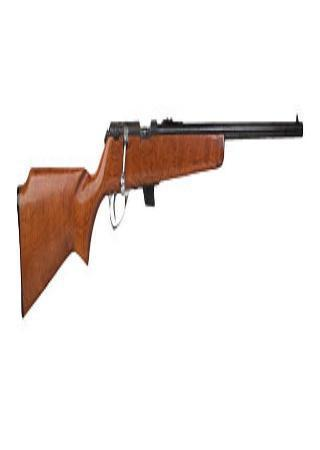
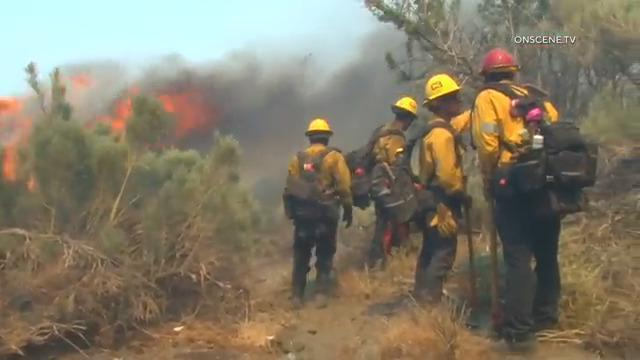
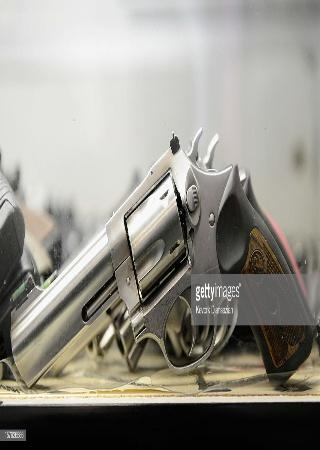
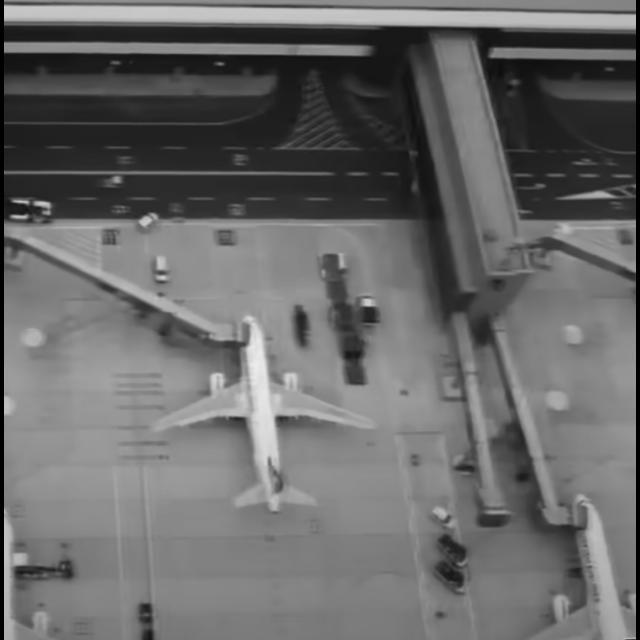
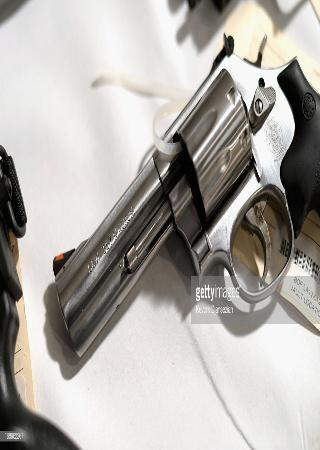
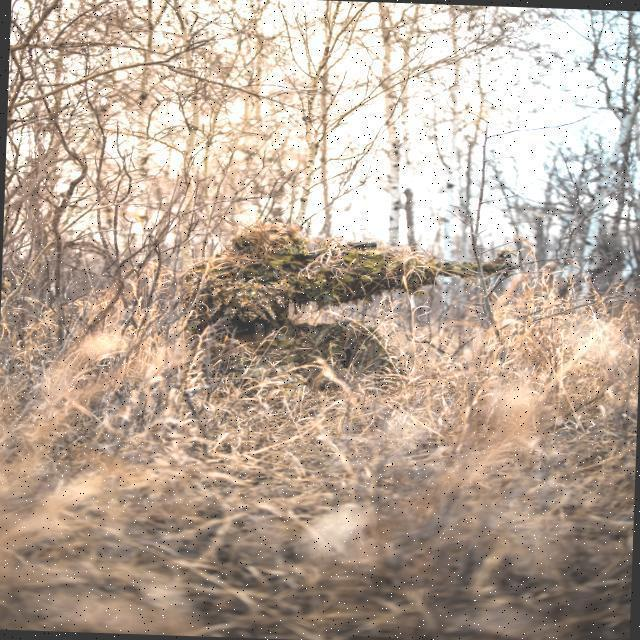

Training Epoch 15/20:   0%|          | 7/2438 [00:04<24:52,  1.63it/s]


KeyboardInterrupt: 

In [13]:
EPOCHS = 20
LR = 5e-4

train_model(train_loader, test_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

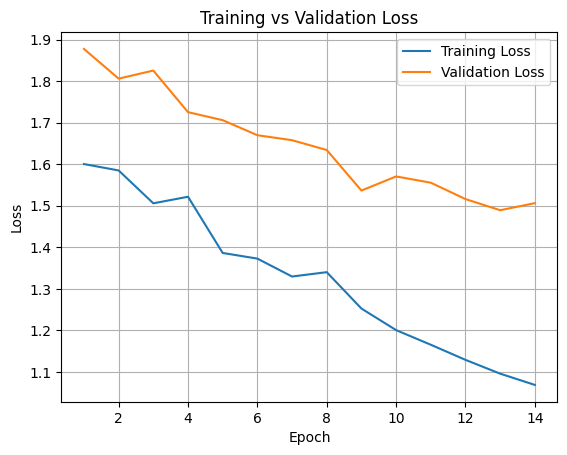

In [14]:
import matplotlib.pyplot as plt

epochs = list(range(1, 15))
train_loss = [1.6004, 1.5850, 1.5059, 1.5217, 1.3864, 1.3728, 1.3297, 1.3402, 1.2526, 1.2007, 1.1655, 1.1291, 1.0959,1.0688]
val_loss = [1.8775, 1.8060, 1.8254, 1.7253, 1.7060, 1.6698, 1.6578, 1.6342, 1.5366, 1.5706, 1.5555, 1.5161, 1.4893,1.5063]

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


## Fine-tuned model evaluation

**NOTE:** It seems that the model can still detect classes that don't belong to our custom dataset.

In [15]:
# @title Collect predictions

PATTERN = r'([A-Za-z]+(-[A-Za-z]+)*)<loc_\d+>'

def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        # print(classes)
        class_set.update(classes)
    return sorted(class_set)

CLASSES = extract_classes(train_dataset)



In [16]:
print(CLASSES)

[('Aircraft', ''), ('Camouflage', ''), ('Drone', ''), ('Fire', ''), ('Grenade', ''), ('Hand-Gun', '-Gun'), ('Knife', ''), ('Military-Vehicle', '-Vehicle'), ('Missile', ''), ('Pistol', ''), ('Rifle', ''), ('Smoke', ''), ('Soldier', '')]


In [17]:
CLASSES = [cls[0] for cls in CLASSES]

In [18]:
print(CLASSES)

['Aircraft', 'Camouflage', 'Drone', 'Fire', 'Grenade', 'Hand-Gun', 'Knife', 'Military-Vehicle', 'Missile', 'Pistol', 'Rifle', 'Smoke', 'Soldier']


In [49]:
import time

targets = []
predictions = []
inference_times = []

for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    # Start timing
    start_time = time.time()

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)

    # Skip if prediction or class names are None
    if prediction is None or prediction['class_name'] is None:
        print(f"⚠️ Skipping sample {i}: No valid prediction.")
        continue

    # Filter to known classes
    prediction = prediction[np.isin(prediction['class_name'], CLASSES)]

    # Again check after filtering (could become empty)
    if len(prediction) == 0:
        print(f"⚠️ Skipping sample {i}: No relevant classes after filtering.")
        continue

    prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))

    # Stop timing
    end_time = time.time()
    inference_time = end_time - start_time
    inference_times.append(inference_time)

    # Process ground truth
    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)

    if target is not None and target['class_name'] is not None:
        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])
    else:
        target.class_id = np.array([])

    targets.append(target)
    predictions.append(prediction)

# Summary stats
if inference_times:
    avg_inference_time = sum(inference_times) / len(inference_times)
    fps = 1 / avg_inference_time if avg_inference_time > 0 else 0
    print(f"\n✅ Average Inference Time per Image: {avg_inference_time:.4f} seconds")
    print(f"✅ Frames Per Second (FPS): {fps:.2f}")
else:
    print("⚠️ No predictions were processed successfully.")


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

⚠️ Skipping sample 31: No valid prediction.


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

⚠️ Skipping sample 57: No valid prediction.


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

⚠️ Skipping sample 148: No valid prediction.


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

⚠️ Skipping sample 301: No valid prediction.


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

⚠️ Skipping sample 310: No valid prediction.


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

⚠️ Skipping sample 765: No valid prediction.


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

⚠️ Skipping sample 871: No valid prediction.


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

⚠️ Skipping sample 1009: No valid prediction.


from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use 

KeyboardInterrupt: 

In [50]:
# @title Calculate mAP for validation set
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.5f}")
print(f"map50: {mean_average_precision.map50:.5f}")
print(f"map75: {mean_average_precision.map75:.5f}")

map50_95: 0.16255
map50: 0.30795
map75: 0.14300


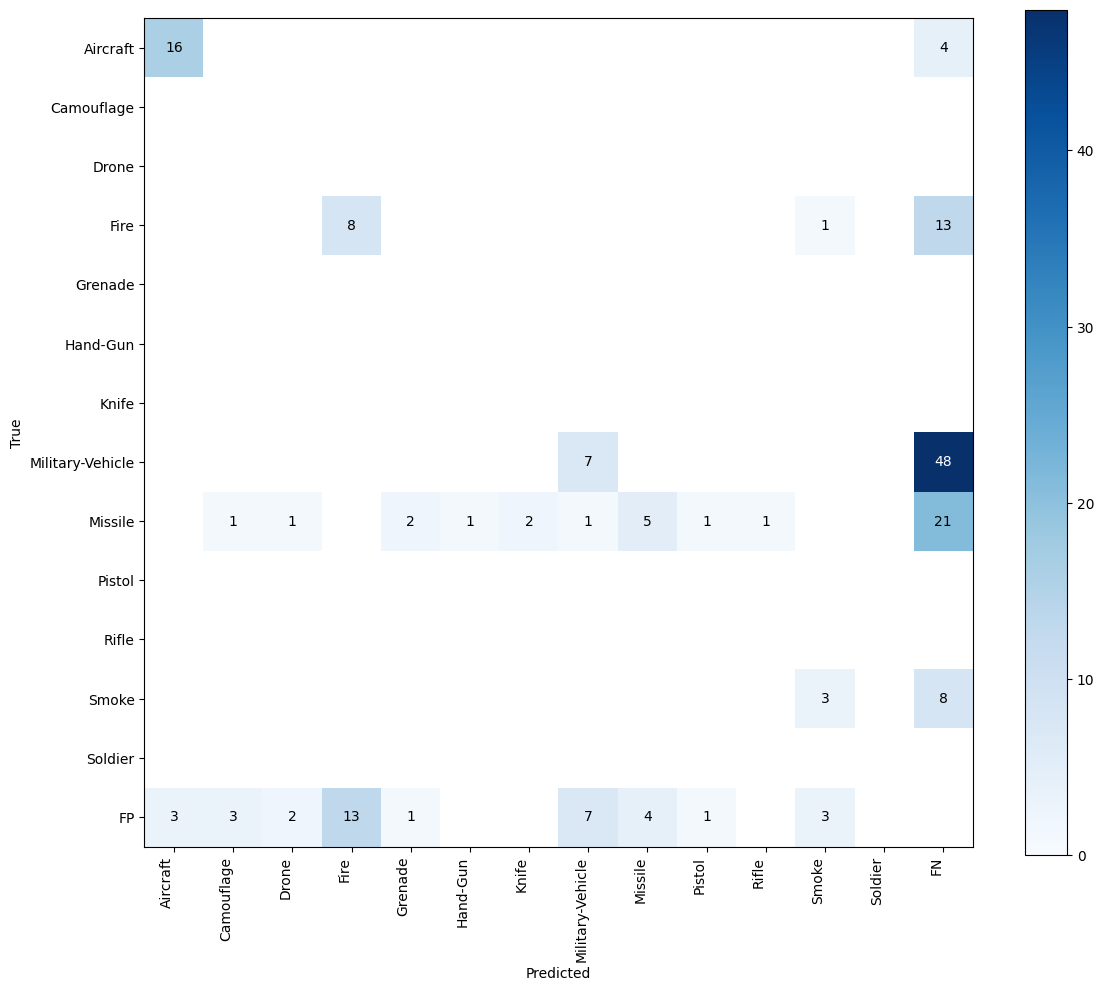

In [21]:
# @title Calculate Confusion Matrix for validation set
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Save fine-tuned model on hard drive

In [25]:
peft_model.save_pretrained("/content/florence2-lora-retrained")
processor.save_pretrained("/content/florence2-lora-retrained/")
!ls -la /content/florence2-lora-retrained/

Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.


total 12848
drwxr-xr-x 2 root root    4096 Apr  5 09:56 .
drwxr-xr-x 1 root root    4096 Apr  5 09:56 ..
-rw-r--r-- 1 root root     817 Apr  5 09:56 adapter_config.json
-rw-r--r-- 1 root root 7747264 Apr  5 09:56 adapter_model.safetensors
-rw-r--r-- 1 root root   22410 Apr  5 09:56 added_tokens.json
-rw-r--r-- 1 root root  456318 Apr  5 09:56 merges.txt
-rw-r--r-- 1 root root     633 Apr  5 09:56 preprocessor_config.json
-rw-r--r-- 1 root root    5102 Apr  5 09:56 README.md
-rw-r--r-- 1 root root  146627 Apr  5 09:56 special_tokens_map.json
-rw-r--r-- 1 root root  197689 Apr  5 09:56 tokenizer_config.json
-rw-r--r-- 1 root root 3747961 Apr  5 09:56 tokenizer.json
-rw-r--r-- 1 root root  798293 Apr  5 09:56 vocab.json


In [23]:
# Saving pretrained models in drive location
peft_model.save_pretrained("/content/drive/MyDrive/florence2-lora-retrained")
processor.save_pretrained("/content/drive/MyDrive/florence2-lora-retrained/")
!ls -la /content/florence2-lora-retrained/

Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.


ls: cannot access '/content/florence2-lora-retrained/': No such file or directory


# Results with test dataset

In [24]:
from PIL import Image
import torch

def predict_image(image_path):
    prompt = '<OD>'
    # Load the image
    image = Image.open(image_path).convert("RGB")  # Ensure it's in RGB format

    # Process input
    inputs = processor(text="", images=image, return_tensors="pt").to(DEVICE)

    # Generate output
    generated_ids = peft_model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )

    # Decode output
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bbox(image, data, figsize=(10, 10)):  # Adjust figsize as needed
    # Create a figure and axes with a larger size
    fig, ax = plt.subplots(figsize=figsize)

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

In [26]:
from tqdm import tqdm  # Progress bar

targets1 = []
predictions1 = []

# Iterate over the dataset with a progress bar
for i in tqdm(range(len(test_dataset.dataset)), desc="Evaluating Model", unit="image"):
    try:
        image, data = test_dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']  # Ground truth annotation

        # Prepare input for the model
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = peft_model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

        # Process model prediction
        prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
        prediction = prediction[np.isin(prediction['class_name'], CLASSES)]

        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))

        target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
        target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])
        targets1.append(target)
        predictions1.append(prediction)

    except Exception as e:
        print(f"Error processing index {i}: {e}")

# Print summary
print(f"\nProcessed {len(targets)} samples successfully.")


Evaluating Model:   0%|          | 0/154 [00:00<?, ?image/s]from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
Evaluating Model:   1%|          | 1/154 [00:00<00:36,  4.17image/s]from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
Evaluating Model:   1%|▏         | 2/154 [00:00<01:09,  2.17image/s]from_lmm is deprecated: `Detections.from_lmm` property is deprecated and will be removed in `supervision-0.31.0`. Use Detections.from_vlm instead.
from_lmm is deprecated: `Detections.from_lmm` property is deprecated 


Processed 57 samples successfully.


In [53]:
# @title Calculate mAP for Test Dataset
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions1,
    targets=targets1,
)

print(f"map50_95: {mean_average_precision.map50_95:.5f}")
print(f"map50: {mean_average_precision.map50:.5f}")
print(f"map75: {mean_average_precision.map75:.5f}")

map50_95: 0.39650
map50: 0.55997
map75: 0.41696


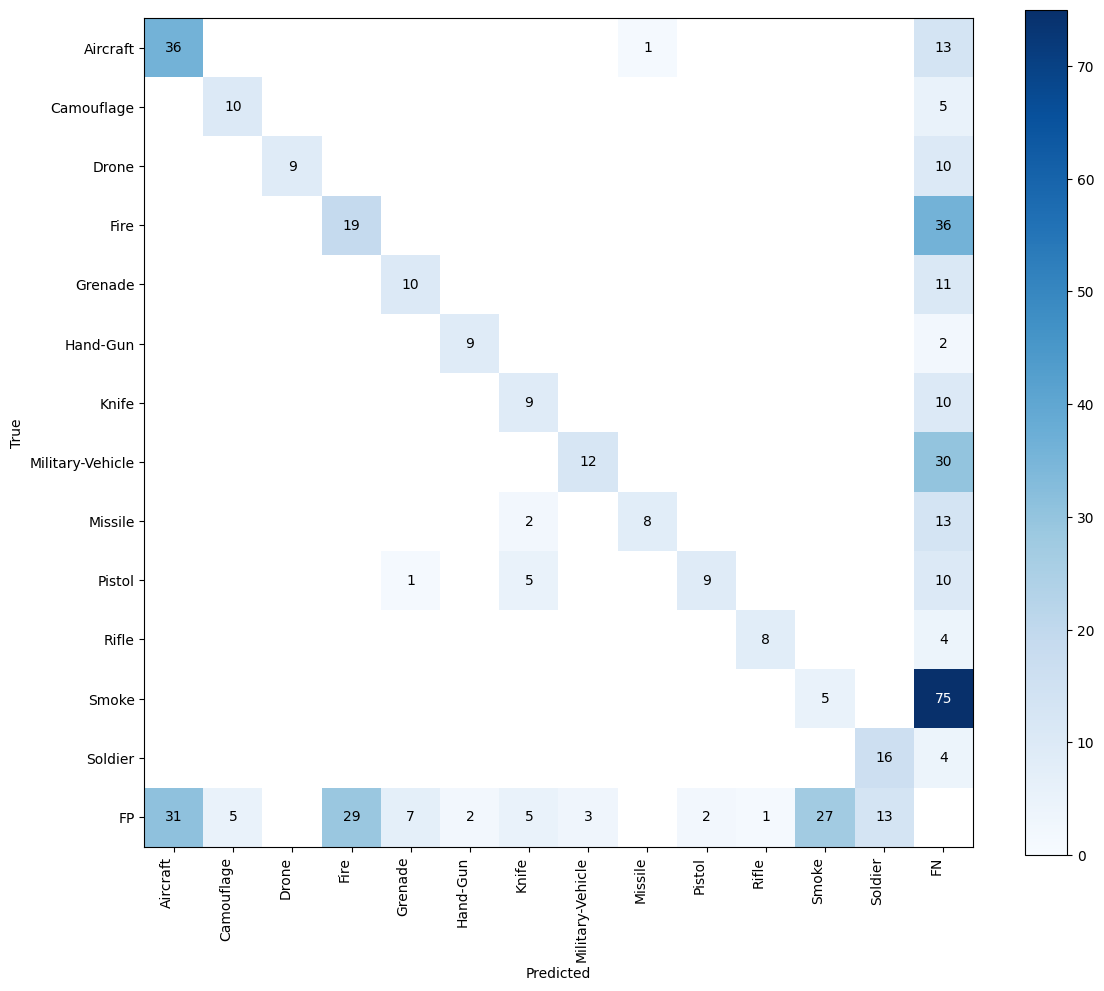

In [28]:
# @title Calculate Confusion Matrix fo test dataset
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions1,
    targets=targets1,
    classes=CLASSES
)

_ = confusion_matrix.plot()

In [43]:
import numpy as np
import pandas as pd

# Function to calculate per-class accuracy
def per_class_accuracy(targets, predictions, class_names):
    class_wise_results = {}

    for class_id, class_name in enumerate(class_names):
        # Get all ground truth instances of the class
        total_targets = sum(class_id in t.class_id for t in targets)

        # Get all correctly predicted instances of the class
        correct_predictions = sum(
            class_id in t.class_id and class_id in p.class_id
            for t, p in zip(targets, predictions)
        )

        # Calculate accuracy
        accuracy = (correct_predictions / total_targets) if total_targets > 0 else 0.0
        class_wise_results[class_name] = round(accuracy * 100, 2)  # Convert to percentage

    return class_wise_results

# Generate accuracy table
accuracy_results = per_class_accuracy(targets1, predictions1, CLASSES)

# Convert to DataFrame for better readability
accuracy_df = pd.DataFrame(list(accuracy_results.items()), columns=["Class", "Accuracy (%)"])

# Calculate average accuracy
average_accuracy = accuracy_df["Accuracy (%)"].mean()

# Display accuracy table and average accuracy
print(accuracy_df)
print(f"\nAverage Accuracy: {average_accuracy:.2f}%")


               Class  Accuracy (%)
0           Aircraft         92.31
1         Camouflage         86.67
2              Drone         90.00
3               Fire         60.00
4            Grenade         92.31
5           Hand-Gun        100.00
6              Knife         63.64
7   Military-Vehicle        100.00
8            Missile         61.54
9             Pistol         81.82
10             Rifle         63.64
11             Smoke         68.42
12           Soldier         85.71

Average Accuracy: 80.47%


Validation dataset

In [51]:
def calculate_per_class_map50(predictions, targets, classes):
    per_class_map50 = {}

    for class_idx, class_name in enumerate(classes):
        class_preds = []
        class_targets = []

        for pred, tgt in zip(predictions, targets):
            pred_mask = pred.class_id == class_idx
            tgt_mask = tgt.class_id == class_idx

            class_preds.append(pred[pred_mask])
            class_targets.append(tgt[tgt_mask])

        # Compute mAP only at IoU 0.5
        class_map = sv.MeanAveragePrecision.from_detections(
            predictions=class_preds,
            targets=class_targets
        )

        per_class_map50[class_name] = class_map.map50

    return per_class_map50

per_class_map50 = calculate_per_class_map50(predictions, targets, CLASSES)

print("\n--- Per-Class mAP@50 ---")
for class_name, map50 in per_class_map50.items():
    print(f"Class: {class_name:15s} | mAP@50: {map50:.5f}")


--- Per-Class mAP@50 ---
Class: Aircraft        | mAP@50: 0.64346
Class: Camouflage      | mAP@50: 0.00000
Class: Drone           | mAP@50: 0.00000
Class: Fire            | mAP@50: 0.27485
Class: Grenade         | mAP@50: 0.00000
Class: Hand-Gun        | mAP@50: 0.00000
Class: Knife           | mAP@50: 0.00000
Class: Military-Vehicle | mAP@50: 0.32079
Class: Missile         | mAP@50: 0.41864
Class: Pistol          | mAP@50: 0.00000
Class: Rifle           | mAP@50: 0.00000
Class: Smoke           | mAP@50: 0.17244
Class: Soldier         | mAP@50: 0.00000


Test dataset

In [52]:
def calculate_per_class_map50(predictions, targets, classes):
    per_class_map50 = {}

    for class_idx, class_name in enumerate(classes):
        class_preds = []
        class_targets = []

        for pred, tgt in zip(predictions, targets):
            pred_mask = pred.class_id == class_idx
            tgt_mask = tgt.class_id == class_idx

            class_preds.append(pred[pred_mask])
            class_targets.append(tgt[tgt_mask])

        # Compute mAP only at IoU 0.5
        class_map = sv.MeanAveragePrecision.from_detections(
            predictions=class_preds,
            targets=class_targets
        )

        per_class_map50[class_name] = class_map.map50

    return per_class_map50

per_class_map50 = calculate_per_class_map50(predictions1, targets1, CLASSES)

print("\n--- Per-Class mAP@50 ---")
for class_name, map50 in per_class_map50.items():
    print(f"Class: {class_name:15s} | mAP@50: {map50:.5f}")


--- Per-Class mAP@50 ---
Class: Aircraft        | mAP@50: 0.61881
Class: Camouflage      | mAP@50: 0.70418
Class: Drone           | mAP@50: 0.73682
Class: Fire            | mAP@50: 0.34419
Class: Grenade         | mAP@50: 0.67189
Class: Hand-Gun        | mAP@50: 0.89965
Class: Knife           | mAP@50: 0.69964
Class: Military-Vehicle | mAP@50: 0.64284
Class: Missile         | mAP@50: 0.67390
Class: Pistol          | mAP@50: 0.68000
Class: Rifle           | mAP@50: 0.83330
Class: Smoke           | mAP@50: 0.10731
Class: Soldier         | mAP@50: 0.85265


In [33]:
# @title Bar Chart: Class-wise Prediction Count
# A bar chart showing how many times each class was predicted.

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def plot_class_distribution(predictions):
    # Count occurrences of each predicted class
    class_counts = Counter(predictions)
    class_labels = [CLASSES[i] for i in class_counts.keys()]
    class_values = list(class_counts.values())

    # Plot Bar Chart
    plt.figure(figsize=(10, 6))
    plt.bar(class_labels, class_values, color='skyblue')
    plt.xlabel("Predicted Classes")
    plt.ylabel("Count")
    plt.title("Class-wise Prediction Count (First 50 Images)")
    plt.xticks(rotation=45)
    plt.show()


In [34]:
# @title Accuracy Per Class (Table)

import pandas as pd

def per_class_accuracy(targets, predictions):
    class_wise_acc = {}

    for class_id in set(targets):
        correct = sum((np.array(targets) == class_id) & (np.array(predictions) == class_id))
        total = sum(np.array(targets) == class_id)
        accuracy = correct / total if total > 0 else 0
        class_wise_acc[CLASSES[class_id]] = round(accuracy, 4)

    # Convert to Pandas DataFrame
    df = pd.DataFrame(list(class_wise_acc.items()), columns=["Class", "Accuracy"])
    print("\nPer-Class Accuracy Table:")
    print(df)


In [35]:
# @title Precision-Recall Curve
# Plots Precision-Recall (PR) Curves to show how well the model balances precision and recall.

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall(targets, predictions):
    precision, recall, _ = precision_recall_curve(targets, predictions, pos_label=1)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (First 50 Images)")
    plt.legend()
    plt.show()


In [36]:
# @title Classification Report

import pandas as pd
from sklearn.metrics import classification_report

def classification_report_table(targets, predictions):
    report = classification_report(targets, predictions, target_names=CLASSES, output_dict=True)
    df = pd.DataFrame(report).transpose()

    print("\nClassification Report Table:")
    print(df)

    return df  # If you want to save or use it further

In [37]:
# @title Pie Chart: Class Distribution
# visualizes the proportion of predictions per class.

def plot_prediction_pie(predictions):
    class_counts = Counter(predictions)
    class_labels = [CLASSES[i] for i in class_counts.keys()]
    class_values = list(class_counts.values())

    plt.figure(figsize=(8, 8))
    plt.pie(class_values, labels=class_labels, autopct="%1.1f%%", colors=plt.cm.Paired.colors)
    plt.title("Predicted Class Distribution (First 50 Images)")
    plt.show()


In [38]:
# @title Line Graph: Accuracy Over Samples
# plots accuracy trend over the first 50 images.

def plot_accuracy_trend(targets, predictions):
    cumulative_accuracy = []
    correct = 0

    for i in range(len(targets)):
        if targets[i] == predictions[i]:
            correct += 1
        cumulative_accuracy.append(correct / (i + 1))

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(targets) + 1), cumulative_accuracy, marker='o', linestyle='-')
    plt.xlabel("Number of Images Evaluated")
    plt.ylabel("Cumulative Accuracy")
    plt.title("Accuracy Trend Over First 50 Images")
    plt.grid(True)
    plt.show()


In [39]:
# Ensure predictions and targets only contain class IDs
processed_targets = []
processed_predictions = []

for pred in predictions1:
    if isinstance(pred, sv.Detections):
        pred_class_ids = pred.class_id.tolist()
        if pred_class_ids:
            processed_predictions.append(pred_class_ids[0])  # Take the first class ID
    else:
        processed_predictions.append(pred)

for target in targets1:
    if isinstance(target, sv.Detections):
        target_class_ids = target.class_id.tolist()
        if target_class_ids:
            processed_targets.append(target_class_ids[0])  # Take the first class ID
    else:
        processed_targets.append(target)


In [40]:
# Ensure both lists have the same length
min_length = min(len(processed_targets), len(processed_predictions))
processed_targets = processed_targets[:min_length]  # Trim extra elements
processed_predictions = processed_predictions[:min_length]  # Trim extra elements


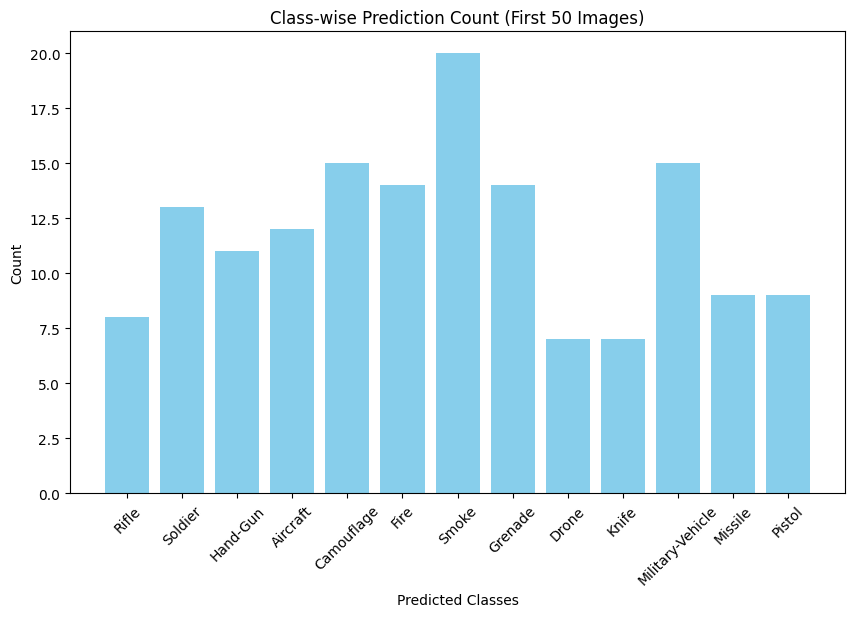


Per-Class Accuracy Table:
               Class  Accuracy
0           Aircraft    0.9231
1         Camouflage    0.8667
2              Drone    0.7000
3               Fire    0.5500
4            Grenade    0.8182
5           Hand-Gun    1.0000
6              Knife    0.0000
7   Military-Vehicle    1.0000
8            Missile    0.6154
9             Pistol    0.5000
10             Rifle    0.6364
11             Smoke    0.6087
12           Soldier    0.8333


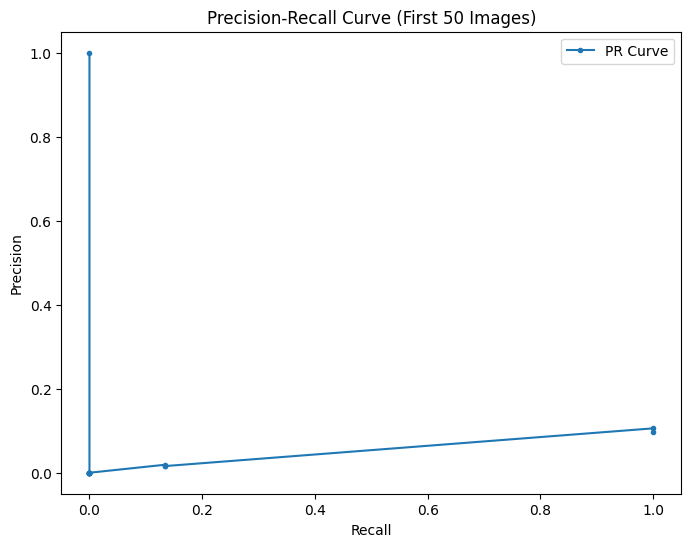

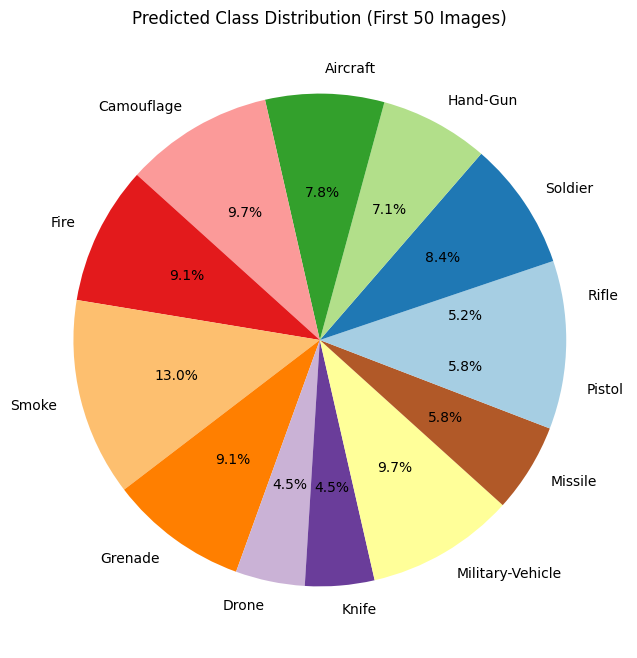

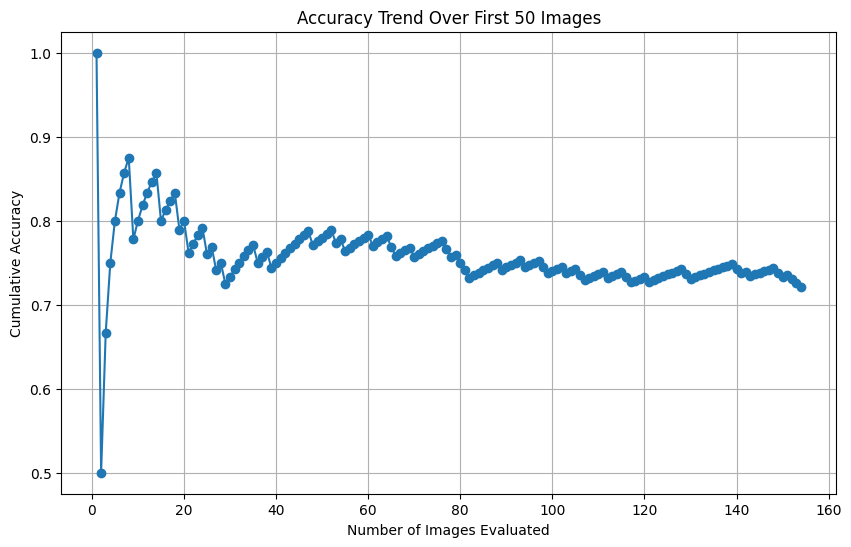

In [41]:
plot_class_distribution(processed_predictions)
per_class_accuracy(processed_targets, processed_predictions)
plot_precision_recall(processed_targets, processed_predictions)
plot_prediction_pie(processed_predictions)
plot_accuracy_trend(processed_targets, processed_predictions)


In [42]:
from sklearn.metrics import classification_report

# Ensure unique class labels are correctly assigned
unique_classes = sorted(set(processed_targets) | set(processed_predictions))  # Get all unique class IDs
filtered_target_names = [CLASSES[i] for i in unique_classes]  # Ensure correct mapping

# Generate classification report
report = classification_report(processed_targets, processed_predictions, target_names=filtered_target_names)
print(report)


                  precision    recall  f1-score   support

        Aircraft       1.00      0.92      0.96        13
      Camouflage       0.87      0.87      0.87        15
           Drone       1.00      0.70      0.82        10
            Fire       0.79      0.55      0.65        20
         Grenade       0.64      0.82      0.72        11
        Hand-Gun       0.91      1.00      0.95        10
           Knife       0.00      0.00      0.00         4
Military-Vehicle       0.80      1.00      0.89        12
         Missile       0.89      0.62      0.73        13
          Pistol       0.33      0.50      0.40         6
           Rifle       0.88      0.64      0.74        11
           Smoke       0.70      0.61      0.65        23
         Soldier       0.38      0.83      0.53         6

        accuracy                           0.72       154
       macro avg       0.71      0.70      0.68       154
    weighted avg       0.77      0.72      0.73       154

